In [1]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'


import sys
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *
from utils.statsTest import lmTest

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import seaborn as sns
import warnings
import commentjson
### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Subset CD8+ T cells

In [2]:
obs_path = f'{RESULT_TABLE}/GEX_OBS_Lineage.csv'
## Load data
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
obs = pd.read_csv(obs_path,index_col=0)

In [3]:
tcells = adata[adata.obs.index.isin(obs.index[obs.Lineage=='T']),:].copy()
tcells.obs['scSHC' ]=pd.read_csv(f"{RESULT_TABLE}/scSHC/T_clusters.csv",index_col=0)['x'].astype(str)

In [4]:
sp.utils.log1pNorm(adata)

## Cluster results from scSHC

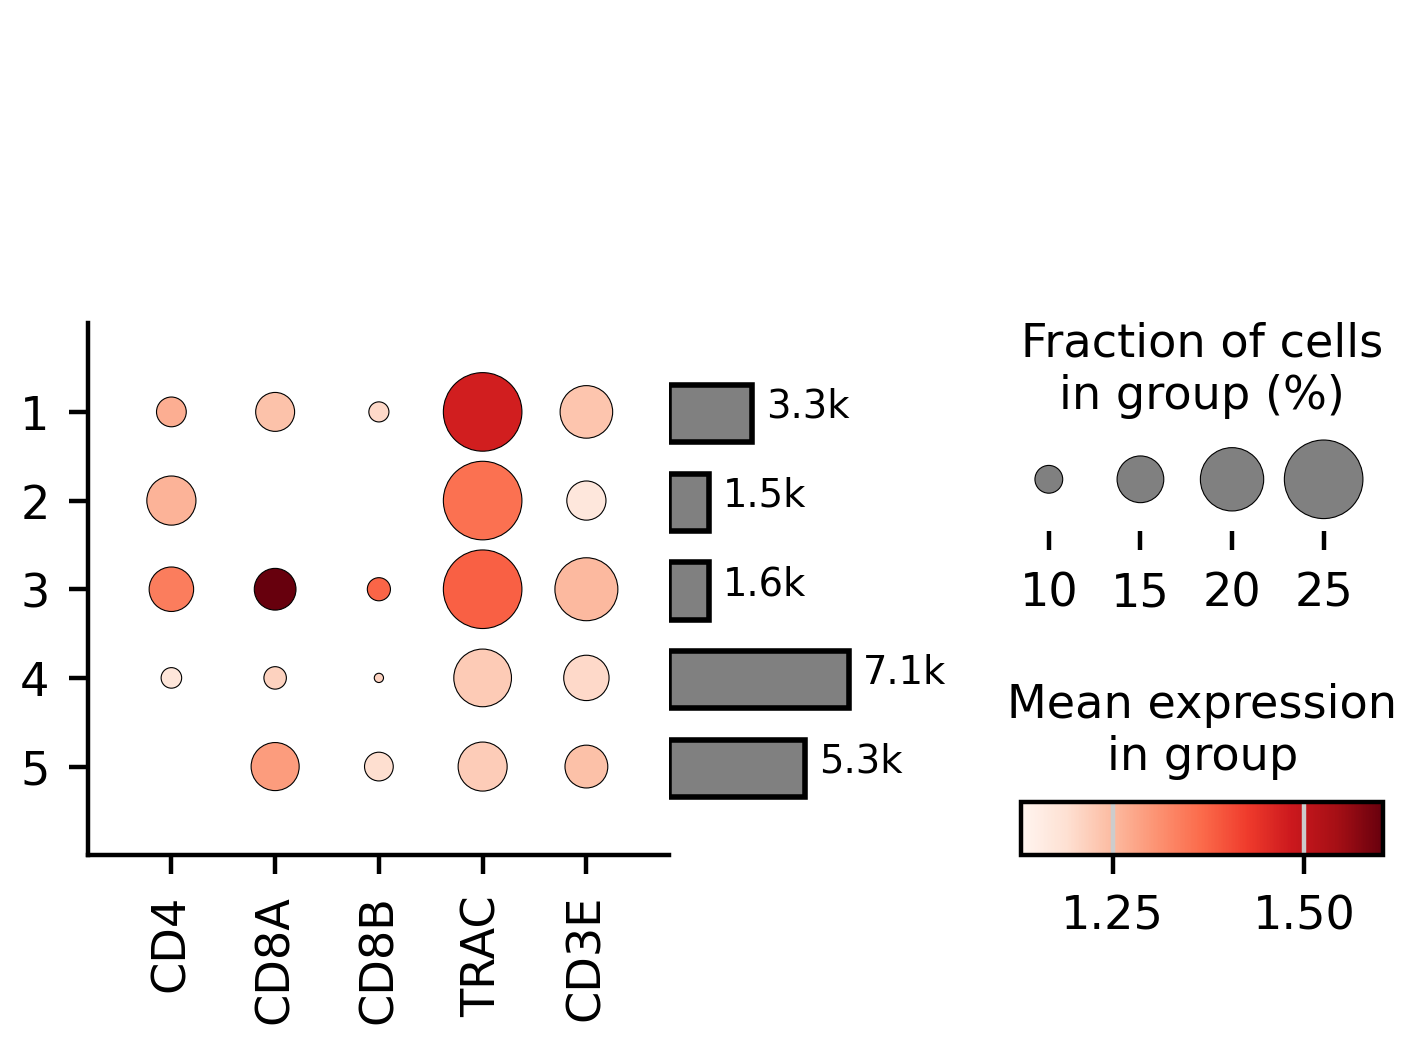

In [5]:
sc.settings.set_figure_params(dpi=200,fontsize=10)
dp = sc.pl.dotplot(tcells,['CD4','CD8A','CD8B','TRAC','CD3E'],groupby='scSHC',mean_only_expressed=True,return_fig=True)
dp.add_totals(color='gray').style(dot_edge_color='black',cmap='Reds',dot_max=.25,dot_min=.05)
dp.show()

In [6]:
tcells.obs['Celltype'] = tcells.obs.scSHC.map({
    '1':'CD8T',
    '2':'CD4T',
    '3':'CD8T',
    '4':'CD8T',
    '5':'CD8T'
})

## Visualize marker genes of CD4 and CD8 t cell

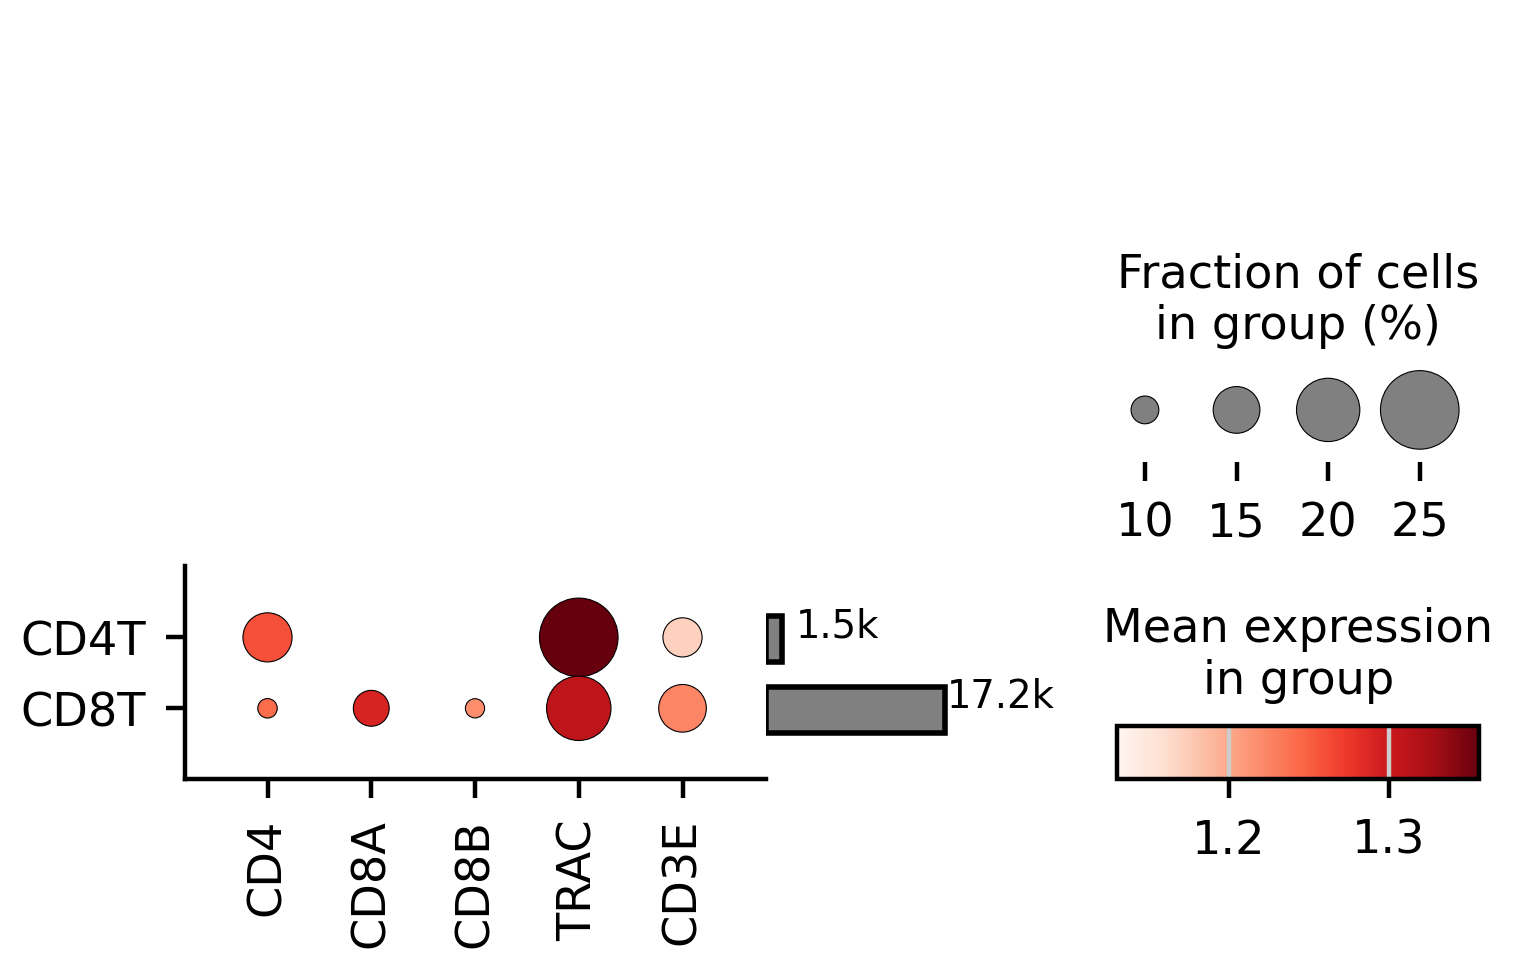

In [7]:
sc.settings.set_figure_params(dpi=200,fontsize=10)
dp = sc.pl.dotplot(tcells,['CD4','CD8A','CD8B','TRAC','CD3E'],groupby='Celltype',mean_only_expressed=True,return_fig=True)
dp.add_totals(color='gray').style(dot_edge_color='black',cmap='Reds',dot_max=.25,dot_min=.05)
dp.show()

## Summarize number of CD8+ and CD4+ T cells

In [8]:
f"We captured {tcells.shape[0]:,} T cells, of which ({(tcells.obs.Celltype=='CD8T').sum()/tcells.shape[0]:.1%}) {(tcells.obs.Celltype=='CD8T').sum():,} most are CD8+ T cells"

'We captured 18,772 T cells, of which (91.8%) 17,230 most are CD8+ T cells'

## Output T lineage cell type annotation

In [9]:
tcells.obs[['Celltype']].to_csv(f"{RESULT_TABLE}/annotation/T.csv")

# Cellstates idenfification of CD8+ T cells using sNMF

- see Suppl Figure3

## Load CD8T cellstate annotation

In [10]:
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
obs = pd.read_csv(f"{RESULT_TABLE}/MPs/CD8T/Annotation.csv",index_col=0)
sample_meta = pd.read_excel(f'{RESULT_TABLE}/Supplementary Table 1.xlsx',index_col=0).replace(np.nan,'N/A')

adata = adata[adata.obs.index.isin(obs.index),:]
adata.obs['Cellstate'] = obs.loc[adata.obs.index,'Cellstate']
adata.obs = adata.obs.merge(sample_meta,left_on='Sample',right_on='CCG_ID')
print(f'{adata.obs.shape[0]:,} CD8 T cells')
adata.obs['Cellstate'].value_counts()

17,230 CD8 T cells


CD8T.Cytotoxic    9453
CD8T.Naive        5392
CD8T.Exhausted    2385
Name: Cellstate, dtype: int64

## Olivera et al CD8T+ signature scores distribution among cellstates

In [95]:
oliveira_sig = (pd.read_excel(f"{EXTERNAL_DATA}/Oliveira_Giacomo_et_al-2021-Nature.xlsx",
                                sheet_name='Supplementary Table 8',
                               skiprows=3).
                   loc[:,:'TTE'].
                   dropna(axis=1,how='all').
                   replace('C16orf45','BMERB1'). # name conversion
                   replace('RARRES3','PLAAT4').
                   replace('SEPT7','SEPTIN7')
                  )
ext_sig_gmt_path =f'{EXTERNAL_DATA}/Oliveira_Giacomo_et_al-2021-Nature.gmt'
with open(ext_sig_gmt_path,'w') as f:
    for c in oliveira_sig:
        f.write('\t'.join([c,'Oliveira_Giacomo_et_al-2021']+oliveira_sig[c].dropna().tolist())+'\n')
    

In [96]:
sc.pp.normalize_total(adata, target_sum=1e4)
mp_result = sp.ext.VISION(data=adata,gmt_files=[ext_sig_gmt_path],outdir='.')

Rscript /home/analysis/scPipe/scPipe/Rscripts/VISION.R --gmt_files ..//data/external/Oliveira_Giacomo_et_al-2021-Nature.gmt --h5ad /tmp/tmpg26ne5th/count.h5ad --output_file /tmp/tmpg26ne5th/vision.tsv
$gmt_files
[1] "..//data/external/Oliveira_Giacomo_et_al-2021-Nature.gmt"

$h5ad
[1] "/tmp/tmpg26ne5th/count.h5ad"

$output_file
[1] "/tmp/tmpg26ne5th/vision.tsv"



/home/analysis/miniconda3/envs/scPipe/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Loading data from ..//data/external/Oliveira_Giacomo_et_al-2021-Nature.gmt ...

Using 21107/36601 genes detected in 0.10% of cells for signature analysis.
See the `sig_gene_threshold` input to change this behavior.

Evaluating signature scores on cells...

'as(<matrix>, "dgeMatrix")' is deprecated.
Use 'as(as(as(., "dMatrix"), "generalMatrix"), "unpackedMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").
Evaluating signature-gene importance...

Warning messages:
1: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 4.7 GiB
2: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 4.7 GiB


In [97]:
mp_result['Cellstate'] = pd.Categorical(adata.obs['Cellstate'],['CD8T.Naive','CD8T.Cytotoxic', 'CD8T.Exhausted'],ordered=True)
mp_result['Sample'] = adata.obs['Sample']

### Linear mixture model on testing the distribution difference of signature scores

In [98]:
result = []
for comparision_list in [['CD8T.Naive','CD8T.Cytotoxic',],
                         ['CD8T.Naive','CD8T.Exhausted',],
                         ['CD8T.Cytotoxic','CD8T.Exhausted']]:
    dt = mp_result.loc[mp_result.Cellstate.isin(comparision_list),:].copy()
    dt.Cellstate =dt.Cellstate.cat.remove_unused_categories()
    result.append(lmTest(dt=dt,Y=['TM','TEM','TPE','TTE','TAct','TProl'],x='Cellstate',Z=[],explored_z=None,random_var='Sample'))
result = pd.concat(result).set_index(['Ctrl','Experiment','Y'])
result

Coef    log2FC  \
Ctrl           Experiment     Y                           
CD8T.Naive     CD8T.Cytotoxic TM    -0.091686 -0.224714   
                              TAct  -0.016055 -0.103974   
                              TPE    0.013144 -0.079495   
                              TProl -0.001912  0.104597   
                              TEM    0.156977   0.28309   
                              TTE    0.116045  0.786031   
               CD8T.Exhausted TProl  0.038709 -0.644946   
                              TM    -0.185147 -0.489505   
                              TEM    -0.14917 -0.459288   
                              TAct    -0.0359 -0.108199   
                              TTE    0.176414  0.940754   
                              TPE    0.261112  1.160134   
CD8T.Cytotoxic CD8T.Exhausted TProl  0.046116 -0.749543   
                              TEM   -0.335395 -0.742378   
                              TM    -0.107258 -0.264791   
                              TAct  -0.024207 -0.004225   
                              TTE    0.060618  0.154722   
                              TPE    0.256841  1.239629   

                                                      Pvalue       FDR  
Ctrl           Experiment     Y                                         
CD8T.Naive     CD8T.Cytotoxic TM       2.337531369918484e-58       0.0  
                              TAct     6.329747630231077e-05  0.000076  
                              TPE     1.6049734642306012e-05  0.000024  
                              TProl      0.29351830656671274  0.293518  
                              TEM     4.553482543191242e-128       0.0  
                              TTE    3.9008029731653834e-302       0.0  
               CD8T.Exhausted TProl   3.7881391210187124e-23       0.0  
                              TM     2.9970279946273392e-102       0.0  
                              TEM      2.805656829802473e-54       0.0  
                              TAct    4.4395130414380445e-10       0.0  
                              TTE     6.183130573328327e-282       0.0  
                              TPE                        0.0       0.0  
CD8T.Cytotoxic CD8T.Exhausted TProl    7.182485930338977e-41       0.0  
                              TEM                        0.0       0.0  
                              TM      3.4710195861387526e-45       0.0  
                              TAct     6.416279947546523e-06  0.000006  
                              TTE       1.44541788062056e-37       0.0  
                              TPE                        0.0       0.0

### Distribution of signature scores among cellstates

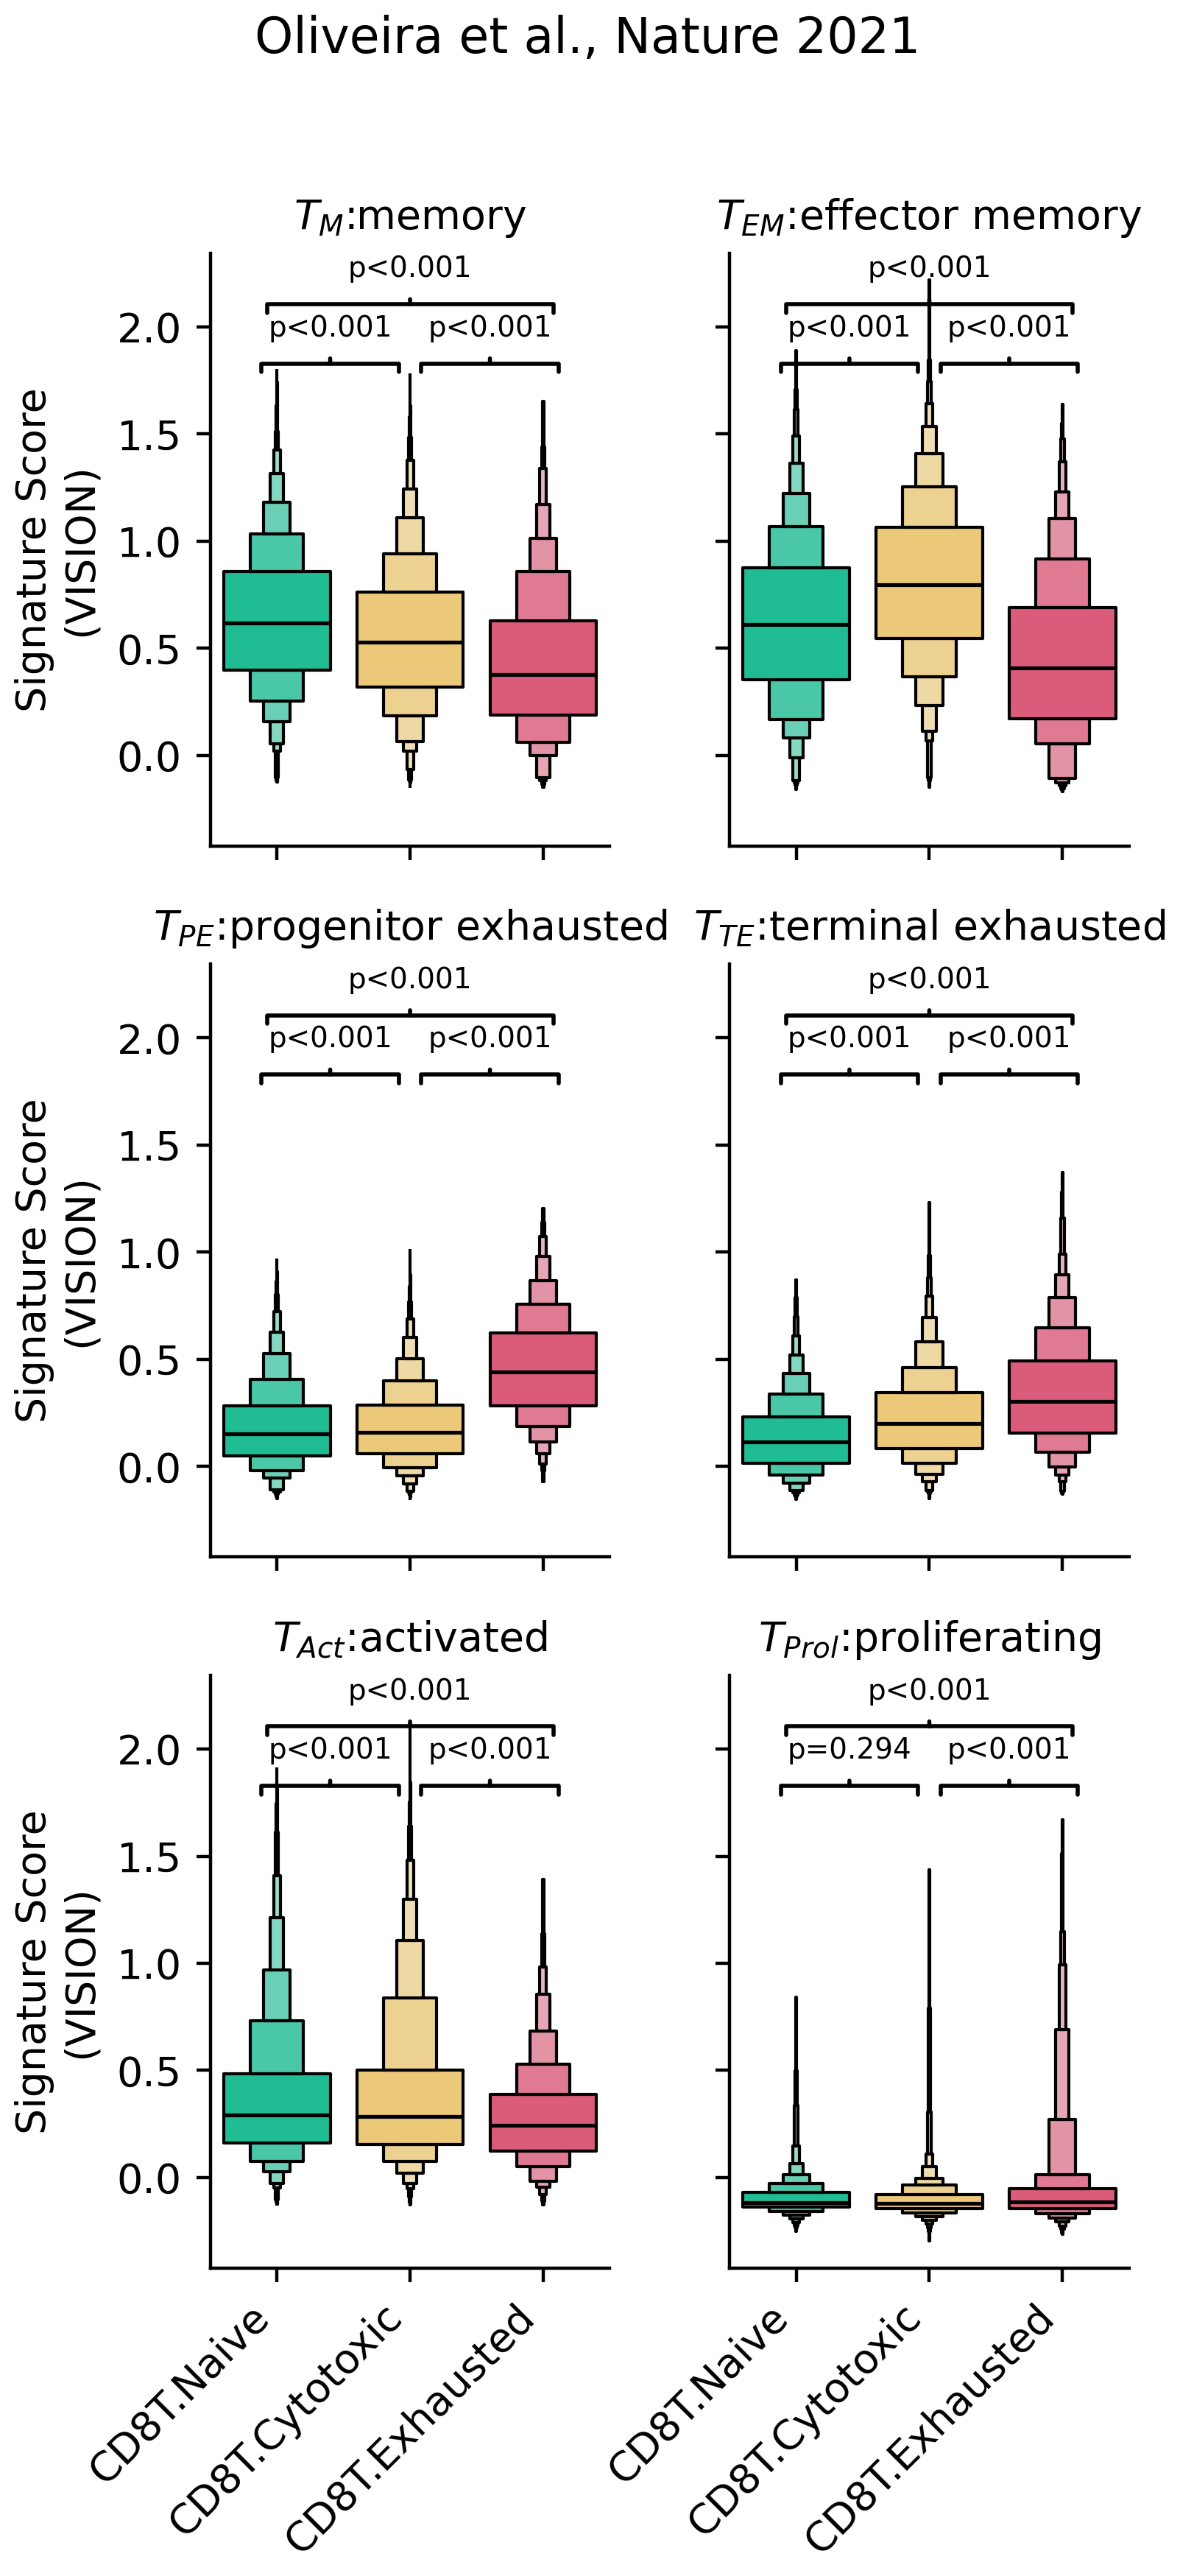

In [99]:
fig,axs = plt.subplots(3,2,sharey=True,sharex=True,dpi=200,figsize=(4,9))
axs = axs.flatten()
title_rename = {
    'TM':r'$T_M$:memory',
    'TEM':r'$T_{EM}$:effector memory',
    'TAct':r'$T_{Act}$:activated',
    'TProl':r'$T_{Prol}$:proliferating',
    'TPE':r'$T_{PE}$:progenitor exhausted',
    'TTE':r'$T_{TE}$:terminal exhausted'
}
for i,y in enumerate(['TM','TEM','TPE','TTE','TAct','TProl']):
    ax=axs[i]
    sns.boxenplot(data=mp_result,x='Cellstate',y=y,
                  showfliers=False,
                       order=[ 'CD8T.Naive','CD8T.Cytotoxic', 'CD8T.Exhausted'],palette=COLOR_PAlETTE['Cellstate'],
                      ax=ax)
    
    ## Pvalue annotation
    pvalue= result.loc[('CD8T.Naive','CD8T.Cytotoxic',y),'Pvalue']
    ax.annotate(f"p={pvalue:.3f}" if pvalue>0.001 else 'p<0.001', xy=(0.3,.8), xytext=(0.3, 0.85), xycoords='axes fraction', 
                fontsize=7, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=2.4, lengthB=.3', lw=1, color='k'))
    
    pvalue= result.loc[('CD8T.Naive','CD8T.Exhausted',y),'Pvalue']
    ax.annotate(f"p={pvalue:.3f}" if pvalue>0.001 else 'p<0.001', xy=(0.5,0.9), xytext=(0.5, .95), xycoords='axes fraction', 
                fontsize=7, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=.3', lw=1, color='k'))
    
    pvalue= result.loc[('CD8T.Cytotoxic','CD8T.Exhausted',y),'Pvalue']
    ax.annotate(f"p={pvalue:.3f}" if pvalue>0.001 else 'p<0.001', xy=(0.7,.8), xytext=(0.7, 0.85), xycoords='axes fraction', 
                fontsize=7, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=2.4, lengthB=.3', lw=1, color='k'))
    ############
    
    ax.set(ylabel='Signature Score\n(VISION)',title=title_rename[y],xlabel='')
    ax.grid(False)
    if i >=4:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Oliveira et al., Nature 2021',y=1);
plt.subplots_adjust(hspace=0.2,wspace=.3)

# Heatmap visualization on genes in each MPs

## Load MPs geneset

In [11]:
mp_anno_path = f'{RESULT_TABLE}/MPs/CD8T/MetaProgram_Annotation.csv'
mp_gmt_path = f'{RESULT_TABLE}/MPs/CD8T/MP_Programs.gmt'
ref_ITH=pd.read_table(mp_gmt_path,header=None,index_col=0).drop([1],axis=1).T
anno = pd.read_csv(mp_anno_path,index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
MP_anno_map_reverse = {v:k for k,v in MP_anno_map.items()}
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram').apply(lambda r:f"{r['MPs']}({r.name})",axis=1).to_dict()
ref_ITH.columns = ref_ITH.columns.map(MP_anno_map)
ref_ITH=ref_ITH.melt()
ref_ITH.columns = ['Program','gene']
ref_ITH = ref_ITH.drop_duplicates(subset=['gene'],keep=False).set_index('gene')

## Visualize MPs in heatmap

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 26.205722222222228 mm


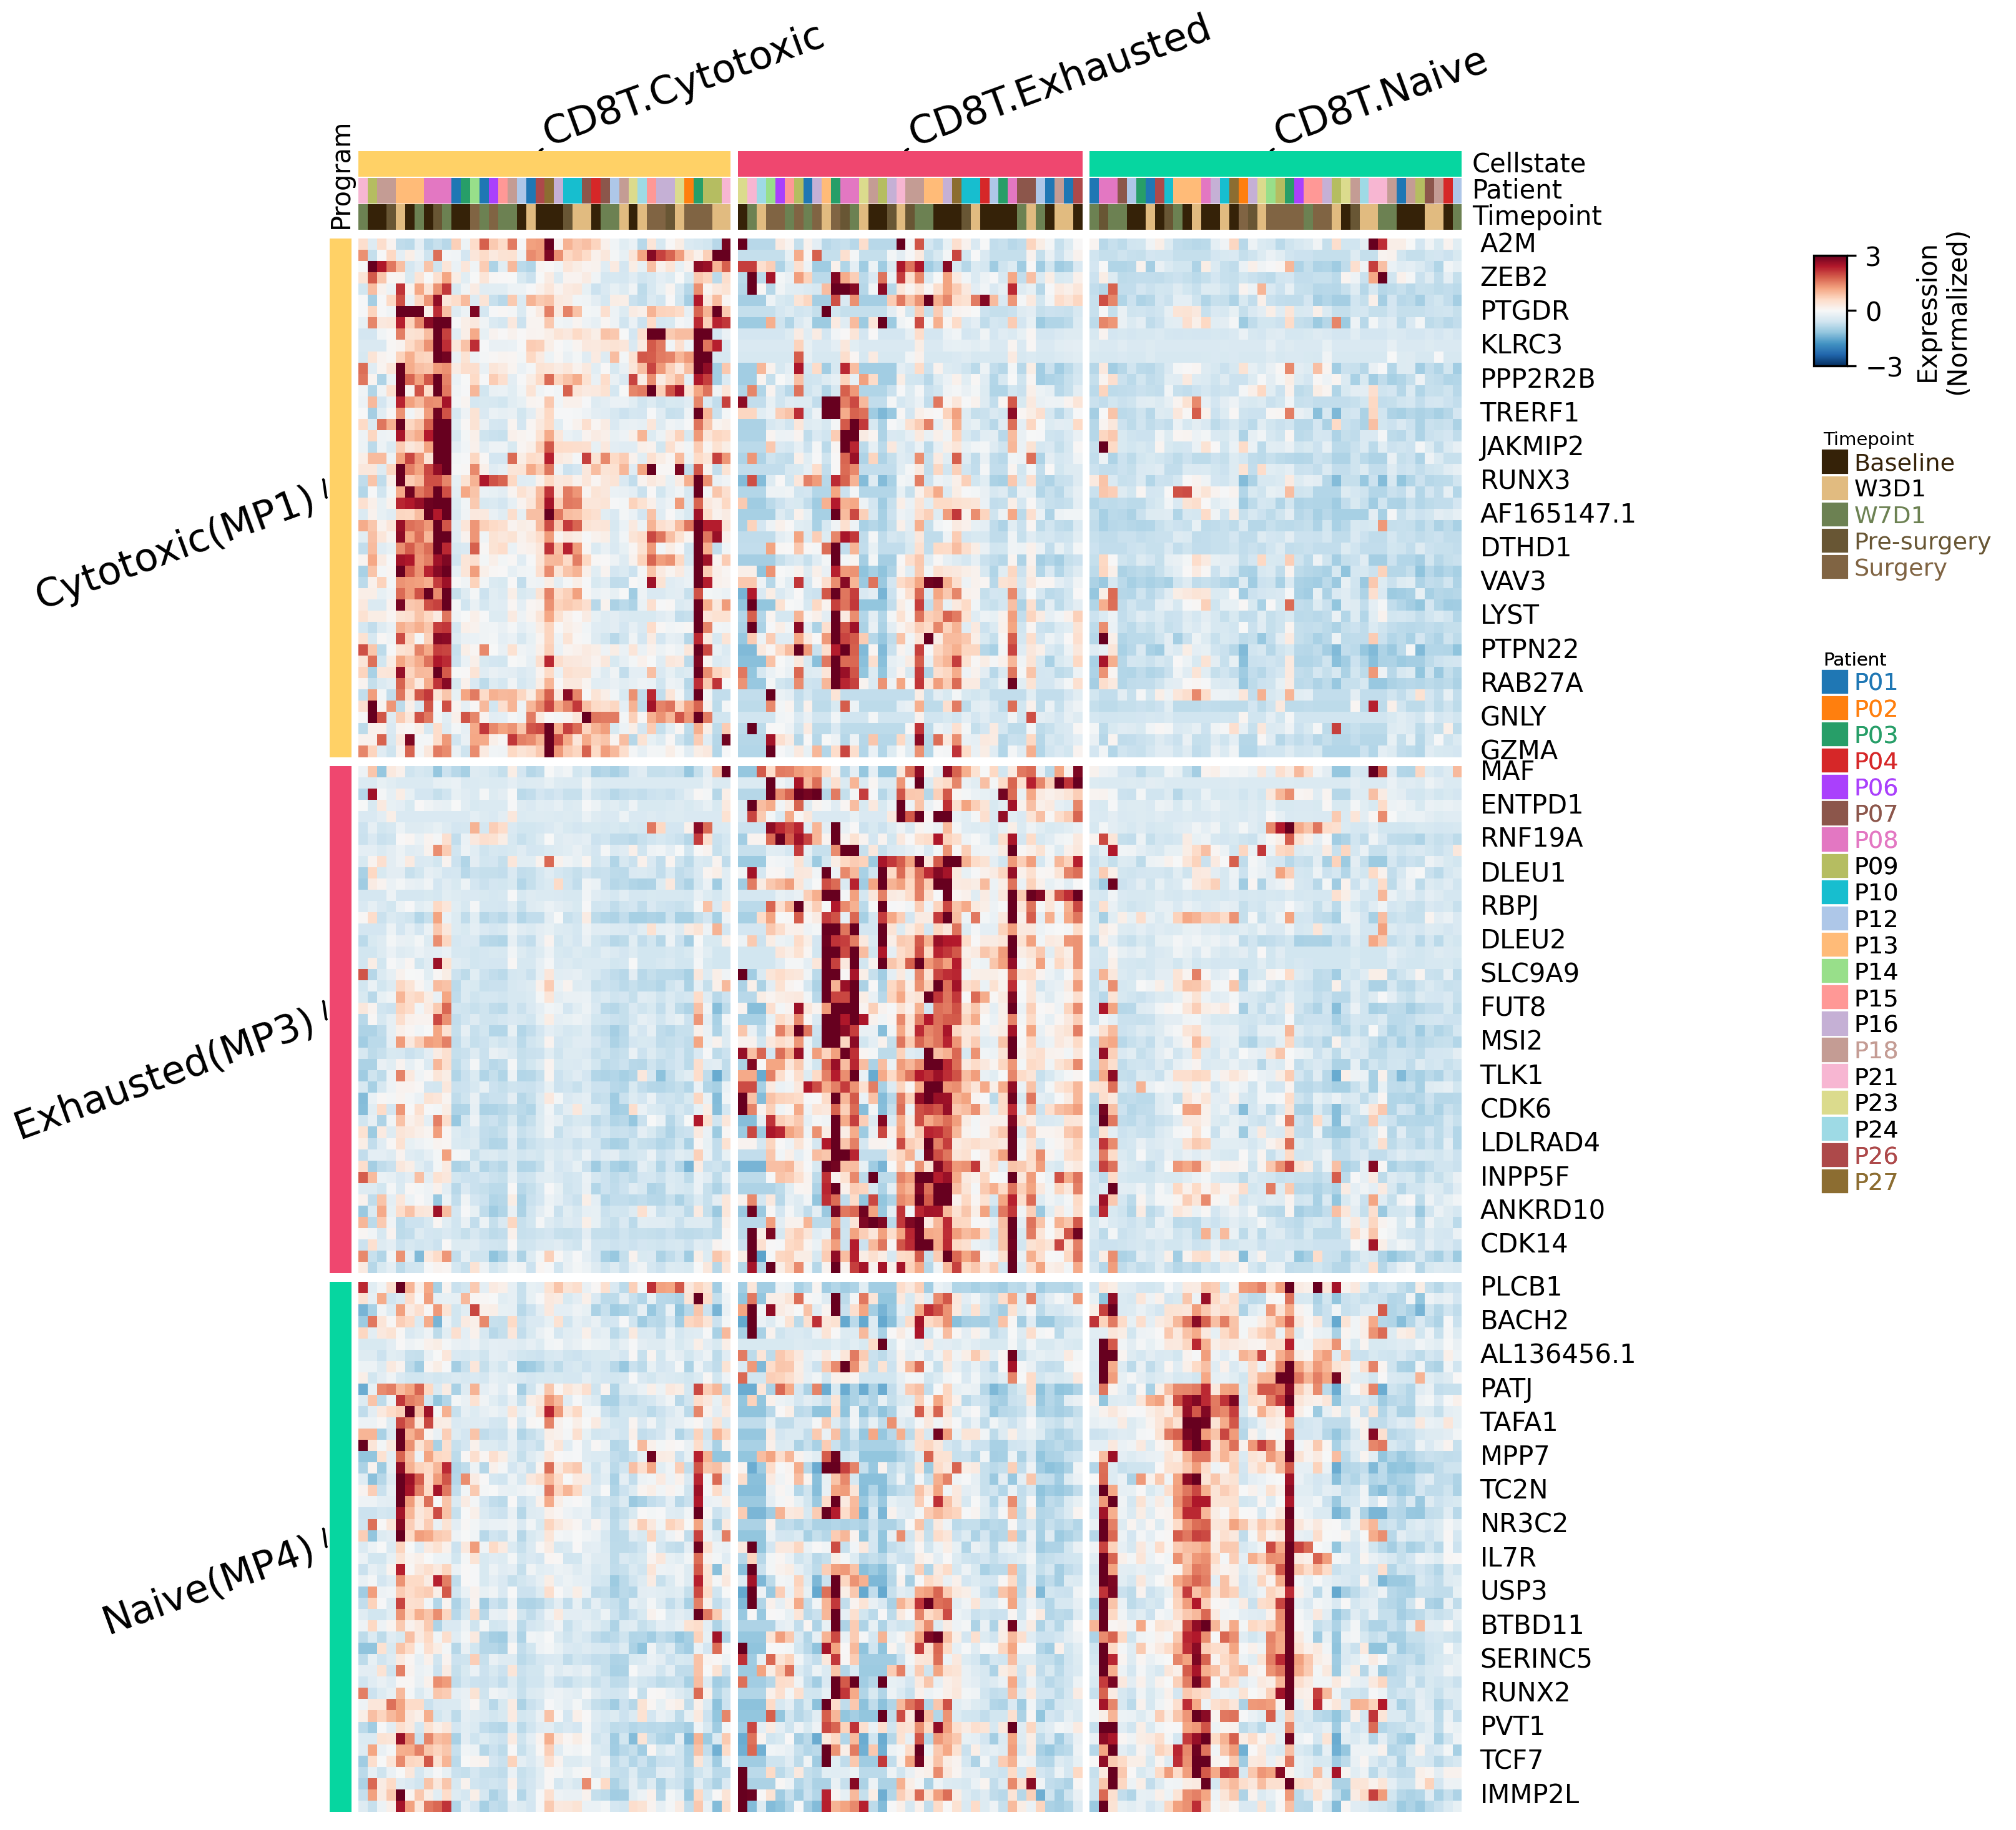

In [12]:
CELLTYPE='CD8T'
palette={}
palette['Program'] = {k.replace(f'{CELLTYPE}.','')+f"({MP_anno_map_reverse[k.replace(f'{CELLTYPE}.','')]})":v for k,v in COLOR_PAlETTE['Cellstate'].items() if CELLTYPE in k}
for c in ['Cellstate','Patient','Timepoint']:
    palette[c] = COLOR_PAlETTE[c]

aggregate_heatmap(adata=adata,
                  features=ref_ITH,
                  top_anno_columns=['Cellstate','Patient','Timepoint'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Program',
                  row_split_gap=1,
                  palette=palette,
                  figsize=(8,10),
                  vmin=-3,
                  vmax=3,
                  standard_normalization=True,
                  cbar_label='Expression\n(Normalized)',
                  cmap='RdBu_r',
                  output_path=f'{FIGURE_FOLDER}/Fig3A_CD8T_MPs_heatmap.svg'
                 )

# The association of MPs signatures with therapy response

In [20]:
anno = pd.read_csv(f'{RESULT_TABLE}/MPs/CD8T/MetaProgram_Annotation.csv',index_col=0)
# MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram').apply(lambda r:f"{r['MPs']}({r.name})",axis=1).to_dict()
# get MP sores on all cells 
scores = pd.read_csv(f'{RESULT_TABLE}/MPs/CD8T/signature_scores.csv',index_col=0)
# scores.columns = scores.map(MP_anno_map)
scores['CCG_ID'] =  scores.index.map(lambda x:'CCG1112'+x.split('CCG1112')[1][:-1])
# attach clinical information
sample_meta = pd.read_excel(f'{RESULT_TABLE}/Supplementary Table 1.xlsx',index_col=0).replace(np.nan,'N/A')
scores = scores.merge(sample_meta,on='CCG_ID',how='left')
scores['BestResponse'] = pd.Categorical(scores.BestResponse,['favorable response\n(RCB 0-I)','unfavorable response\n(RCB II-III)'],ordered=True)

## DEGs NR vs R

In [26]:
degs = pd.read_excel(f'{RESULT_TABLE}/DEGs_Response/CD8T.xlsx',sheet_name='R',index_col=0)
gmt = pd.read_table(f'{RESULT_TABLE}/MPs/CD8T/MP_Programs.gmt',header=None,index_col=0).drop([1],axis=1).T
gmt.rename(columns=MP_anno_map,inplace=True)

Text(0, -0.15, 'Unfavorable\n(RCB=II-III)')

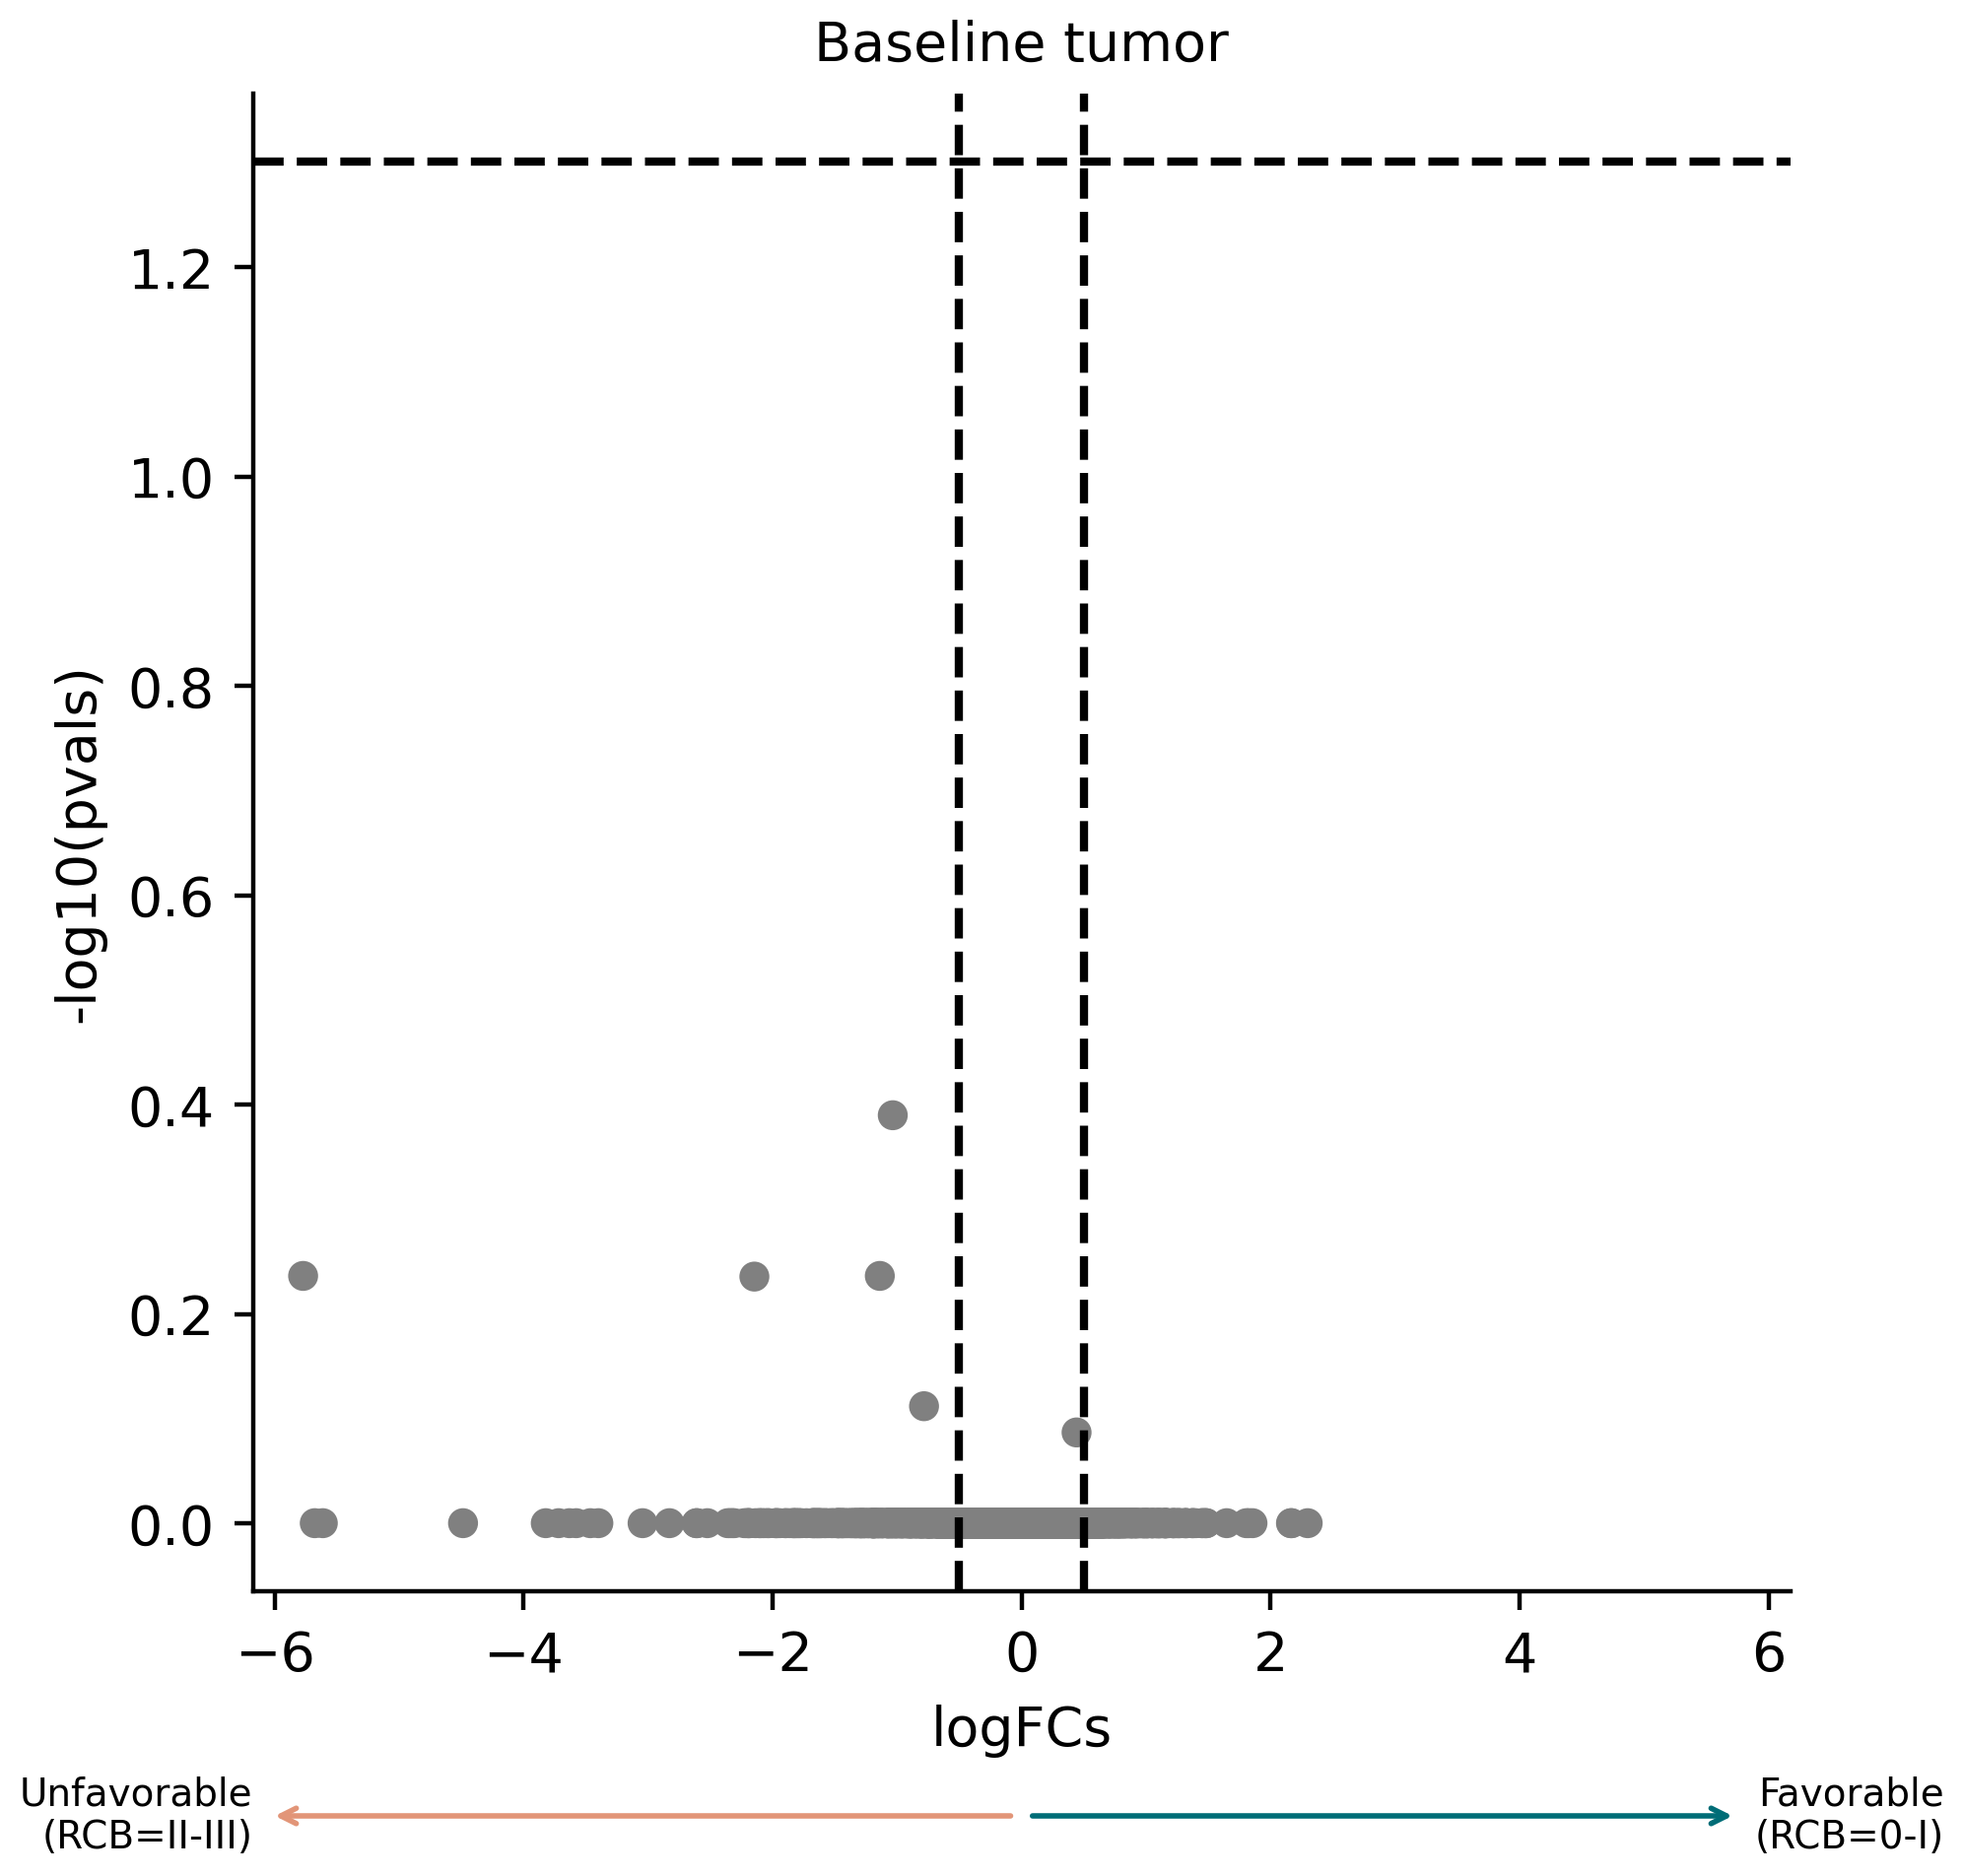

In [27]:
show_genes = degs.index[degs.index.isin(gmt['Cytotoxic(MP1)']) & (degs.padj<0.05) & (degs.log2FoldChange<.5)].tolist()
fig,ax= plot_volcano_df(
    degs,
    x='log2FoldChange',
    y='padj',
    show_list=show_genes,
    figsize=(5, 5),
    dpi=200
)
ax.set(title='Baseline tumor');
xmax = np.abs(ax.get_xlim()).max()
ax.set_xlim([-xmax,xmax])
center=0.5
name ='Favorable\n(RCB=0-I)'
ax.annotate(name, xy=(center, -0.15), xycoords='axes fraction', xytext=(1.1, -0.15), 
            arrowprops=dict(arrowstyle="<-", color='#006d77'),ha='right',va='center')
name ='Unfavorable\n(RCB=II-III)'
ax.annotate(name, xy=(center, -0.15), xycoords='axes fraction', xytext=(0, -0.15), 
            arrowprops=dict(arrowstyle="<-",  color='#e29578'),ha='right',va='center')

## Baseline prediction power
### Differences caused by the lead-in treatment

In [28]:
x='BestResponse'
timepoints =['Baseline']
explored_z=None
random_var='Patient'
x_order=['favorable response\n(RCB 0-I)','unfavorable response\n(RCB II-III)']
dt = scores.loc[(scores.Timepoint.isin(timepoints)),:].copy()
dt[x] = pd.Categorical(dt[x],x_order,ordered=True)
output_table = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var).replace(MP_anno_map)
output_table.to_csv(f'{RESULT_TABLE}/LmTest/CD8T_Baseline_Prediction.csv',index=False)
pvalues = output_table.set_index(['Y'])['Pvalue']
output_table

,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,FDR
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Cytotoxic(MP1),-0.167325,-0.186081,0.443978097601323,0.847406
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Exhausted(MP3),-0.093928,-0.106872,0.5649370134827459,0.847406
0,favorable response\n(RCB 0-I),unfavorable response\n(RCB II-III),Naive(MP4),0.009076,0.006041,0.9775693394832082,0.977569


### Distribution of MPs between two RCB groups

In [29]:
dt.groupby(['BestResponse'])['CCG_ID'].nunique()

BestResponse
favorable response\n(RCB 0-I)         3
unfavorable response\n(RCB II-III)    9
Name: CCG_ID, dtype: int64

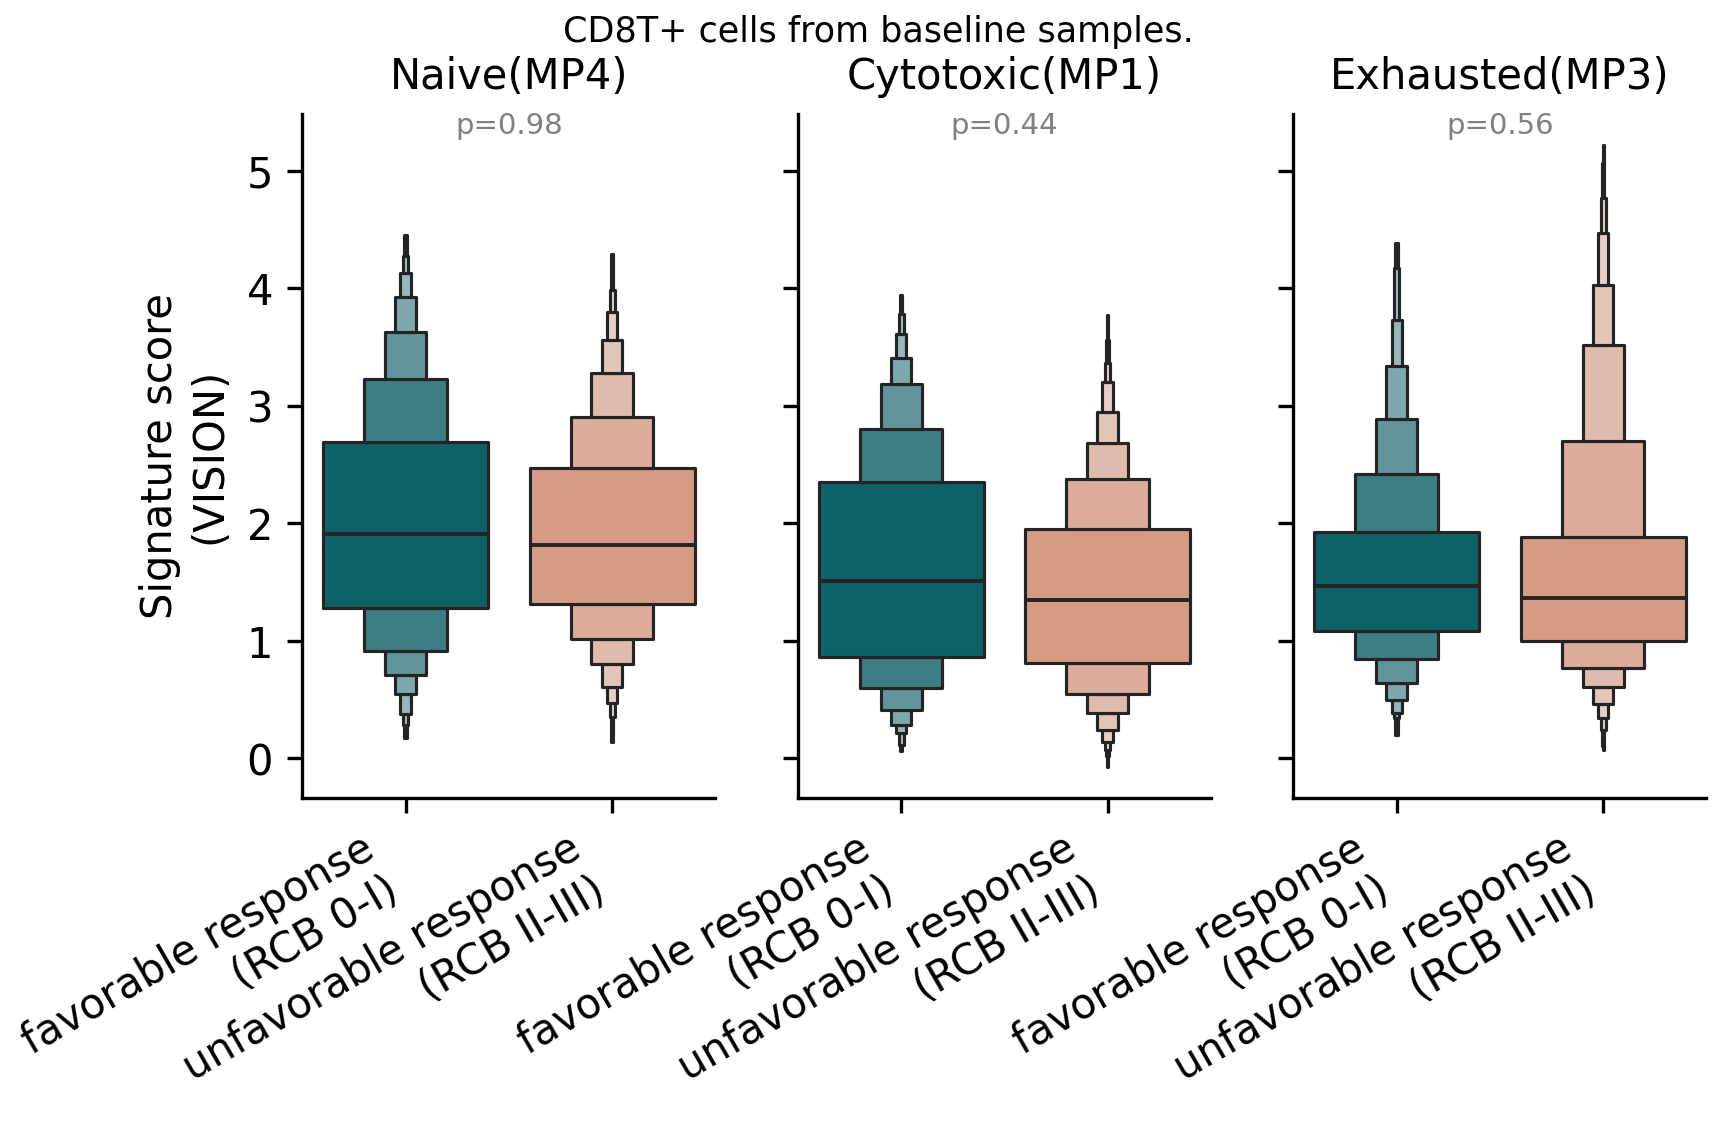

In [31]:
show_mps = ['Naive(MP4)','Cytotoxic(MP1)','Exhausted(MP3)']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,3,dpi=150,sharey=True,figsize=(6,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.boxenplot(data=plt_dt,
                  ax=ax,x=x,y=subtype,hue=x,
                  showfliers=False,
                  palette=COLOR_PAlETTE[x])
    # ax.legend_.remove()
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    y_loc =5.5
    pvalue = pvalues[subtype]
    if pvalue >= 0.05:
        c='gray'
        label = f"p={pvalue:.2f}"
    else:
        label = f"p={pvalue:.3f}"
        c = 'red'
    ax.text(.5,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
plt.suptitle('CD8T+ cells from baseline samples.',y=1.02)
plt.savefig(f"{FIGURE_FOLDER}/Suppl_3F_CD8T_MPs_baseline_NRvsR.svg",dpi=200,bbox_inches='tight')

### Relative cellular abundance difference between two RCB groups
perform wilcoxon test to compare the abudance difference between two groups

In [32]:
from scipy.stats import ranksums
timepoint='Baseline'
cellstate_col = 'Cellstate'
obs = pd.read_csv(f"{RESULT_TABLE}/MPs/CD8T/Annotation.csv",index_col=0)
obs['CCG_ID'] =  obs.index.map(lambda x:'CCG1112'+x.split('CCG1112')[1][:-1])
ra = (pd.crosstab(obs[cellstate_col],obs['CCG_ID']) / obs.CCG_ID.value_counts()).T
# get RCB response groups map
sp_bp_map = sample_meta.set_index('CCG_ID')['BestResponse'].to_dict()
# perform statistic test per treatment arm
stats_result =[]
for tx_arm in ['ICI->Combo','Chemo->Combo']:
    dt = ra.loc[sample_meta.CCG_ID[(sample_meta.Treatment_Arm==tx_arm)&
                                  (sample_meta.Timepoint==timepoint)],:]
    
    ## order by the z score between R vs NR
    ##### stats_result on the distribution of relative abundance of each state
    stats_dt = dt.apply(lambda v: pd.Series(ranksums(v[v.index.map(sp_bp_map)=='favorable response\n(RCB 0-I)'], 
                                                     v[v.index.map(sp_bp_map)=='unfavorable response\n(RCB II-III)']),
                                            index=['statstics','Pvalue'],name=v.name),
                        axis=0).T
    stats_dt['Treatment_Arm'] = tx_arm
    stats_result.append(stats_dt.reset_index())
pvalues = pd.concat(stats_result).set_index(['Cellstate','Treatment_Arm'])['Pvalue']
pvalues


Cellstate       Treatment_Arm
CD8T.Cytotoxic  ICI->Combo       0.738883
CD8T.Exhausted  ICI->Combo       0.182422
CD8T.Naive      ICI->Combo       0.504985
CD8T.Cytotoxic  Chemo->Combo     0.179712
CD8T.Exhausted  Chemo->Combo     0.654721
CD8T.Naive      Chemo->Combo     0.179712
Name: Pvalue, dtype: float64

### Distribution of CD8T+ cellstate relative abundance between two RCB groups

Text(0.5, 1.02, 'CD8T+ cells from baseline samples.')

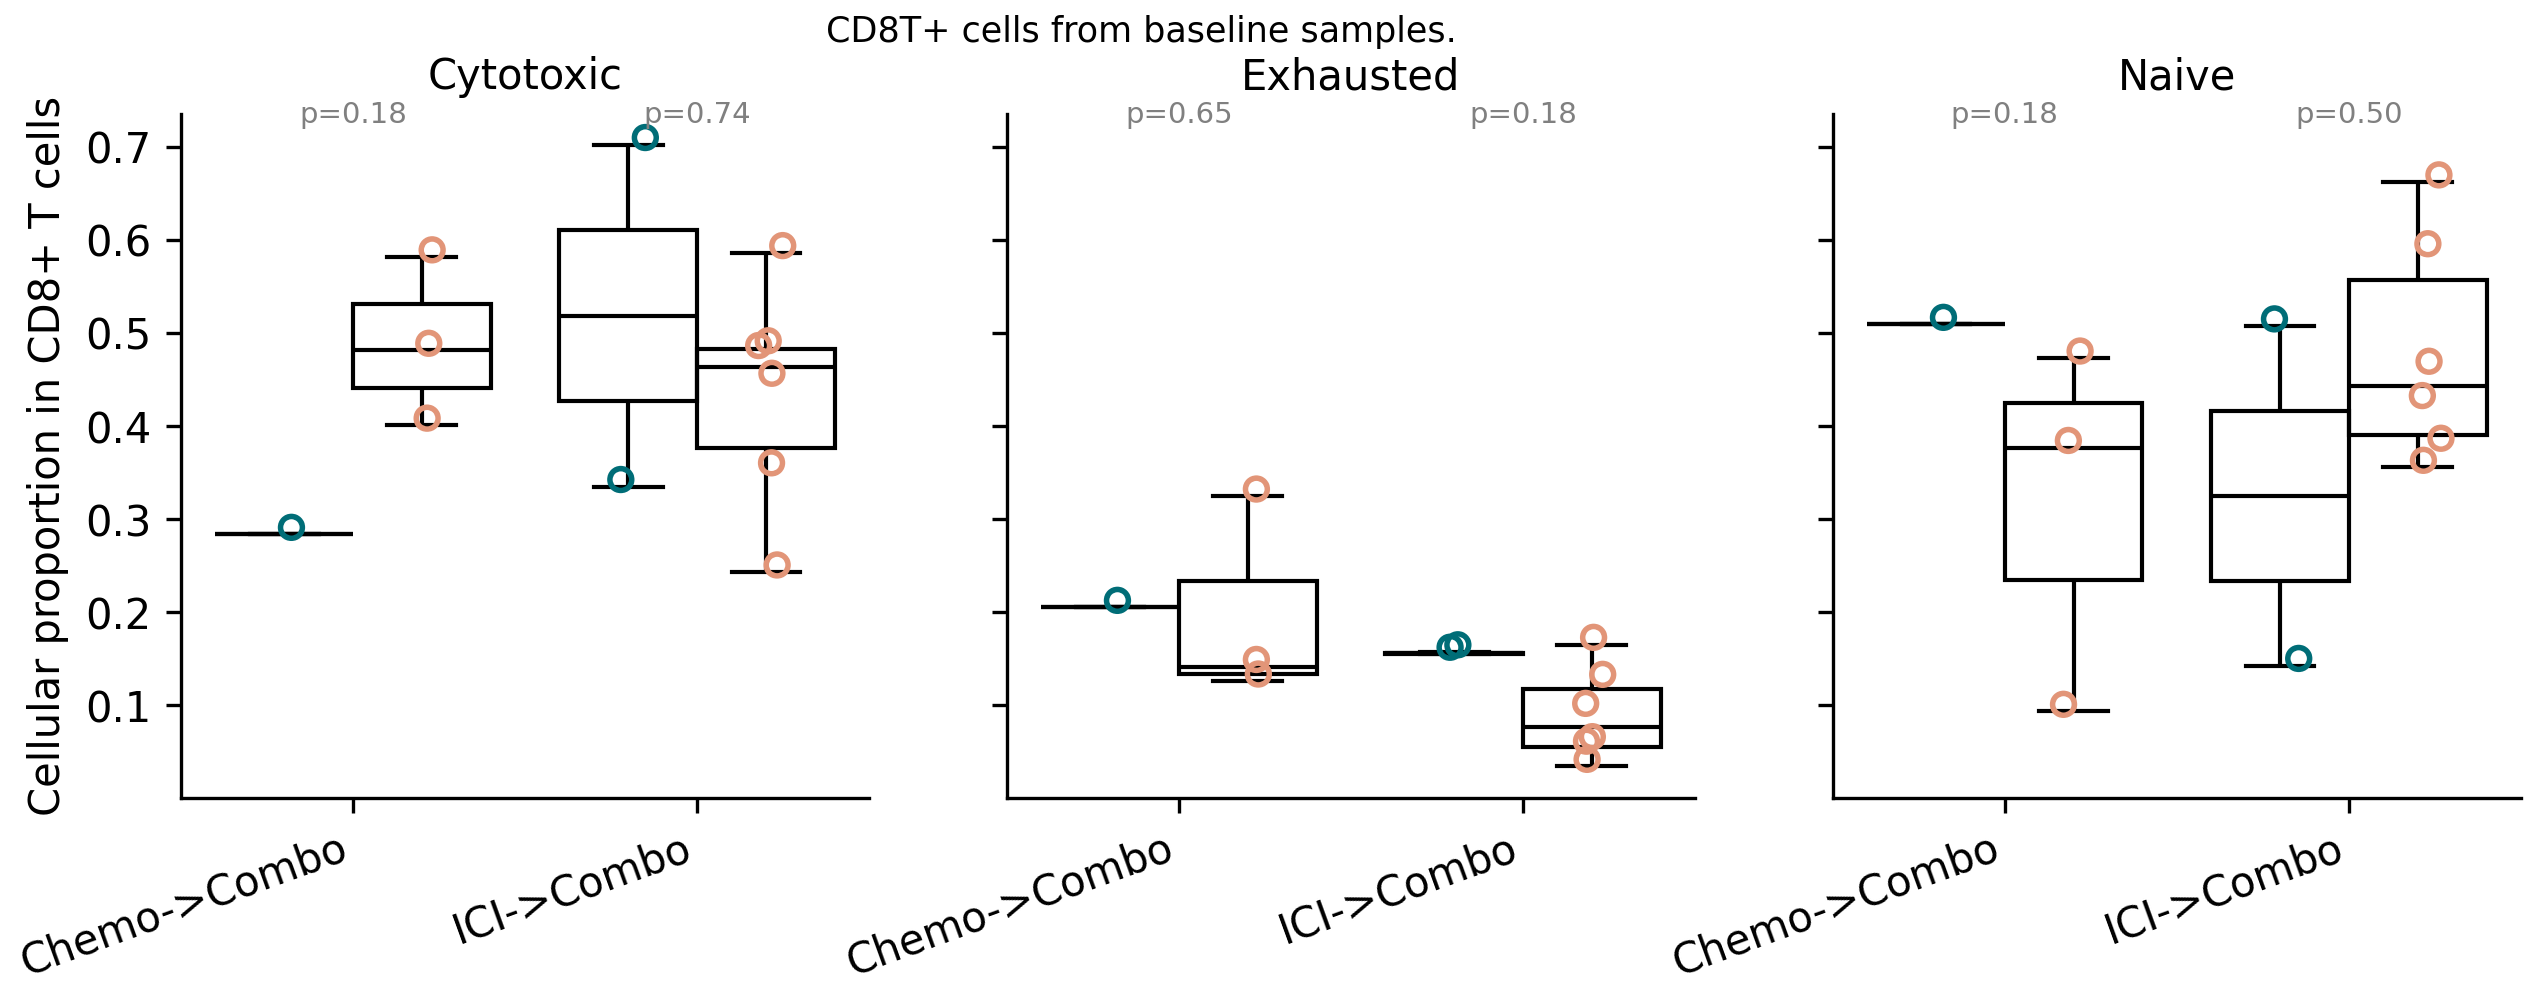

In [33]:
groupby='Treatment_Arm'
x = 'BestResponse'
fig,axs=plt.subplots(1,3,dpi=150,sharey=True,figsize=(10,3))
## boxplot parameters
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
filled_marker_style = dict(marker='o', linestyle=':', 
                           color='darkgrey',
                           edgecolor='brown')
##
for i,subtype in enumerate(ra.columns.tolist()):
    ax=axs[i]
    plt_dt = ra.loc[sample_meta.CCG_ID[sample_meta.Timepoint==timepoint],:]
    plt_dt[groupby] = sample_meta.set_index('CCG_ID').loc[plt_dt.index,groupby]
    plt_dt[x] =  sample_meta.set_index('CCG_ID').loc[plt_dt.index,x]
    sns.stripplot(data=plt_dt,
                  ax=ax,x=groupby,y=subtype,hue=x,
                  dodge=True,
                  palette=COLOR_PAlETTE[x], marker="$\circ$", size=10)
    sns.boxplot(data=plt_dt,
                ax=ax,x=groupby,y=subtype,hue=x,showfliers=False,linewidth=1,**PROPS)
    ax.legend_.remove()
    ax.set(xlabel='',title=subtype.replace('CD8T.',''),ylabel='Cellular proportion in CD8+ T cells')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
    y_loc =.75
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        else:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
plt.suptitle('CD8T+ cells from baseline samples.',y=1.02)

# Treatment-induced program shifts

## Monotherapy
### Chemotherapy induced MPs shift

In [34]:
tx_arm = 'Chemo->Combo'
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W3D1']))&
                (scores.Treatment_Arm==tx_arm),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         1
unfavorable response\n(RCB II-III)    1
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,Baseline,W3D1,Exhausted(MP3),0.056083,-0.014511,0.3147307345150969,favorable response\n(RCB 0-I),0.314731
0,Baseline,W3D1,Exhausted(MP3),0.129888,-0.014511,0.09823055143205203,unfavorable response\n(RCB II-III),0.098231
0,Baseline,W3D1,Exhausted(MP3),0.07367,0.091582,0.11871500856037386,favorable response\n(RCB 0-I)+unfavorable resp...,0.118715
0,Baseline,W3D1,Naive(MP4),0.674595,0.110455,3.0909097619719313e-43,favorable response\n(RCB 0-I),0.0
0,Baseline,W3D1,Naive(MP4),0.435465,0.110455,2.5331395543145094e-05,unfavorable response\n(RCB II-III),0.000076
0,Baseline,W3D1,Naive(MP4),0.617613,0.393649,1.181984674305048e-44,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,Baseline,W3D1,Cytotoxic(MP1),0.50746,0.462155,1.4942478733467095e-26,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,Baseline,W3D1,Cytotoxic(MP1),0.59535,0.497942,4.913718431205078e-27,favorable response\n(RCB 0-I),0.0
0,Baseline,W3D1,Cytotoxic(MP1),0.226512,0.497942,0.010031306581553618,unfavorable response\n(RCB II-III),0.015047


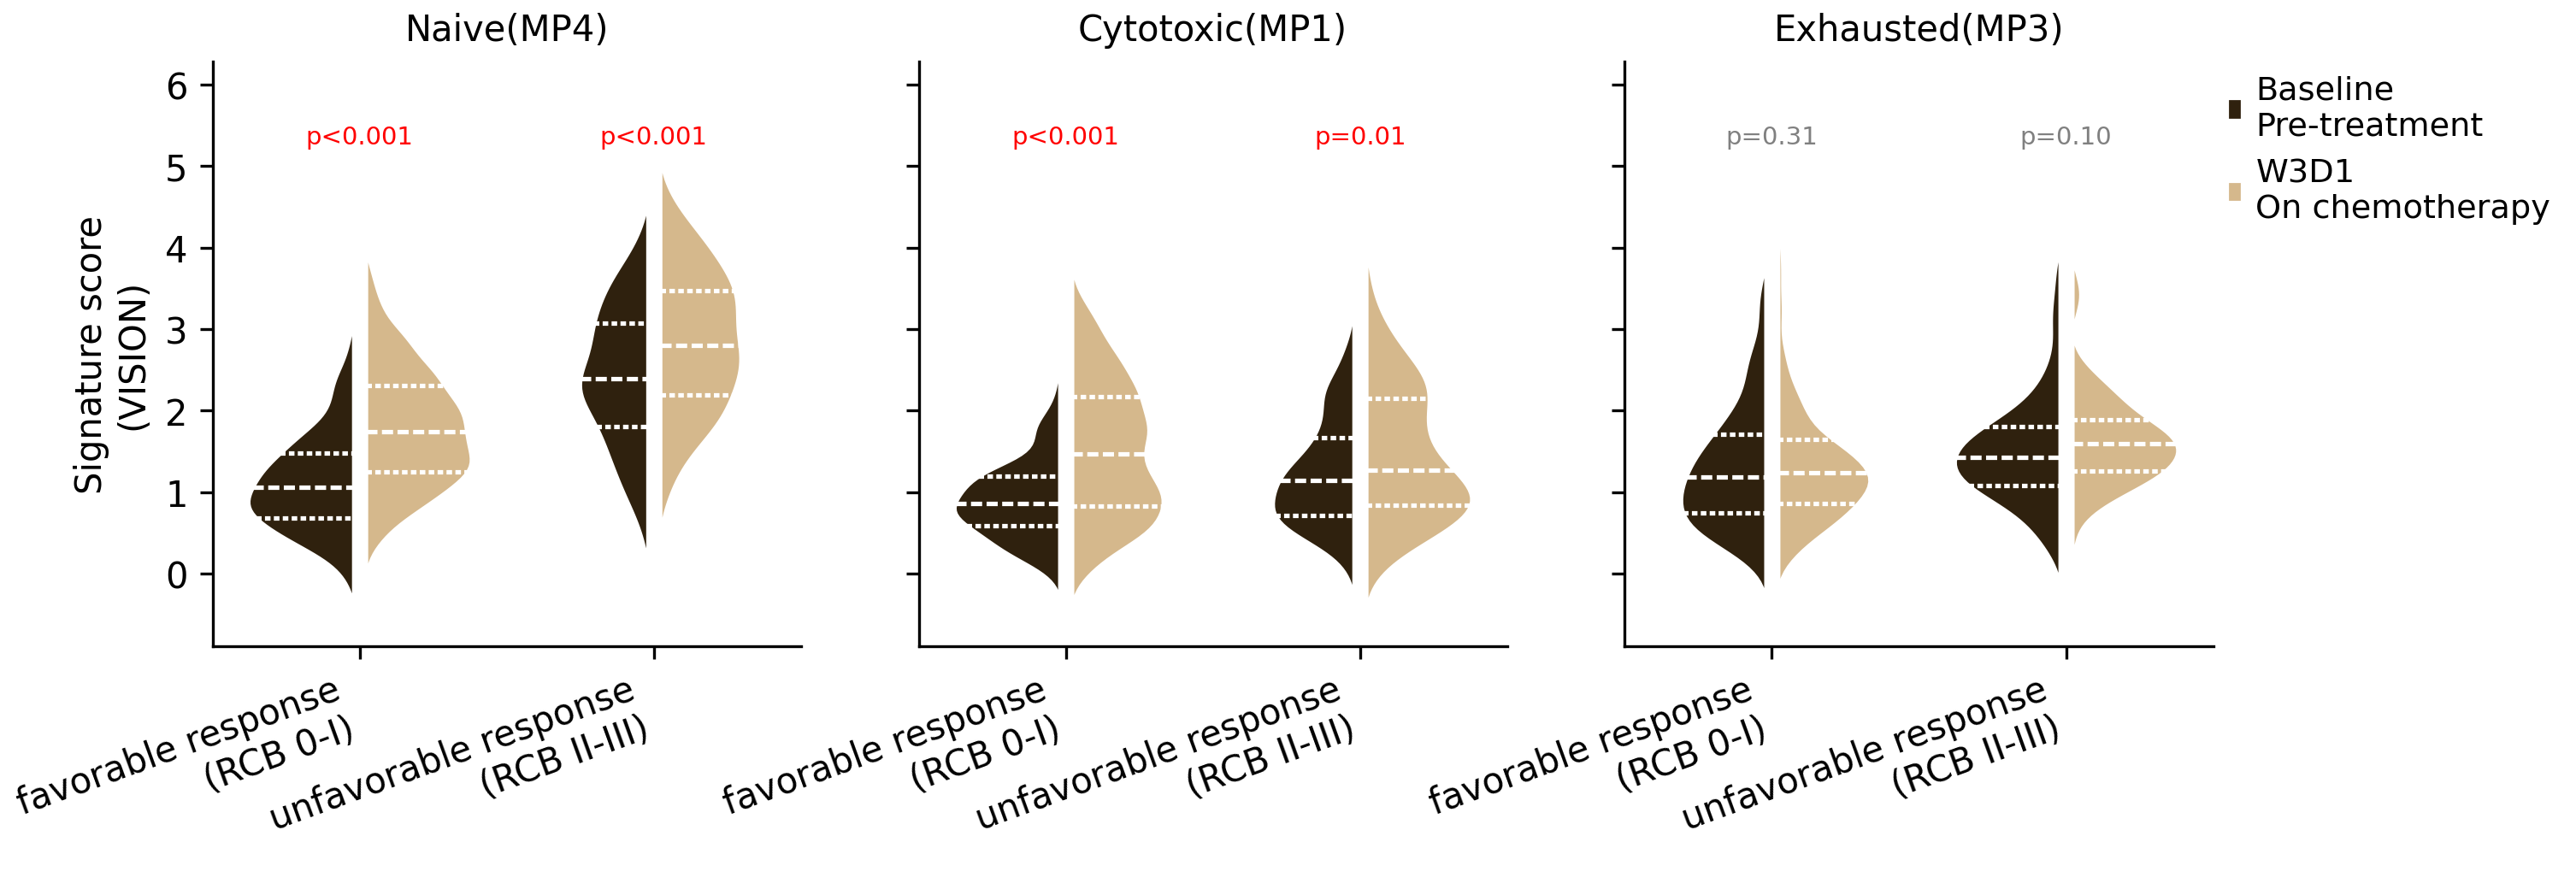

In [36]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,3,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=2:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'Baseline':'Baseline\nPre-treatment',
                        'W3D1':'W3D1\nOn chemotherapy'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')

fig.savefig(f"{FIGURE_FOLDER}/Fig3D_CD8T_MPs_changes_chemoVsBaseline.svg",dpi=200,bbox_inches='tight')

### Pembro induced MPs shifts

In [37]:
tx_arm = 'ICI->Combo'
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['Baseline','W3D1']))&
                (scores.Treatment_Arm==tx_arm),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['Baseline','W3D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
dt[explored_z] = dt[explored_z].astype(str)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var).drop_duplicates(['Y',explored_z])
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         0
unfavorable response\n(RCB II-III)    3
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,Baseline,W3D1,Naive(MP4),0.154276,0.008867,0.06151887112210351,unfavorable response\n(RCB II-III),0.061519
0,Baseline,W3D1,Exhausted(MP3),0.29754,0.12216,0.0012497890454924606,unfavorable response\n(RCB II-III),0.00287
0,Baseline,W3D1,Cytotoxic(MP1),0.214083,0.234924,0.001913642884678725,unfavorable response\n(RCB II-III),0.00287


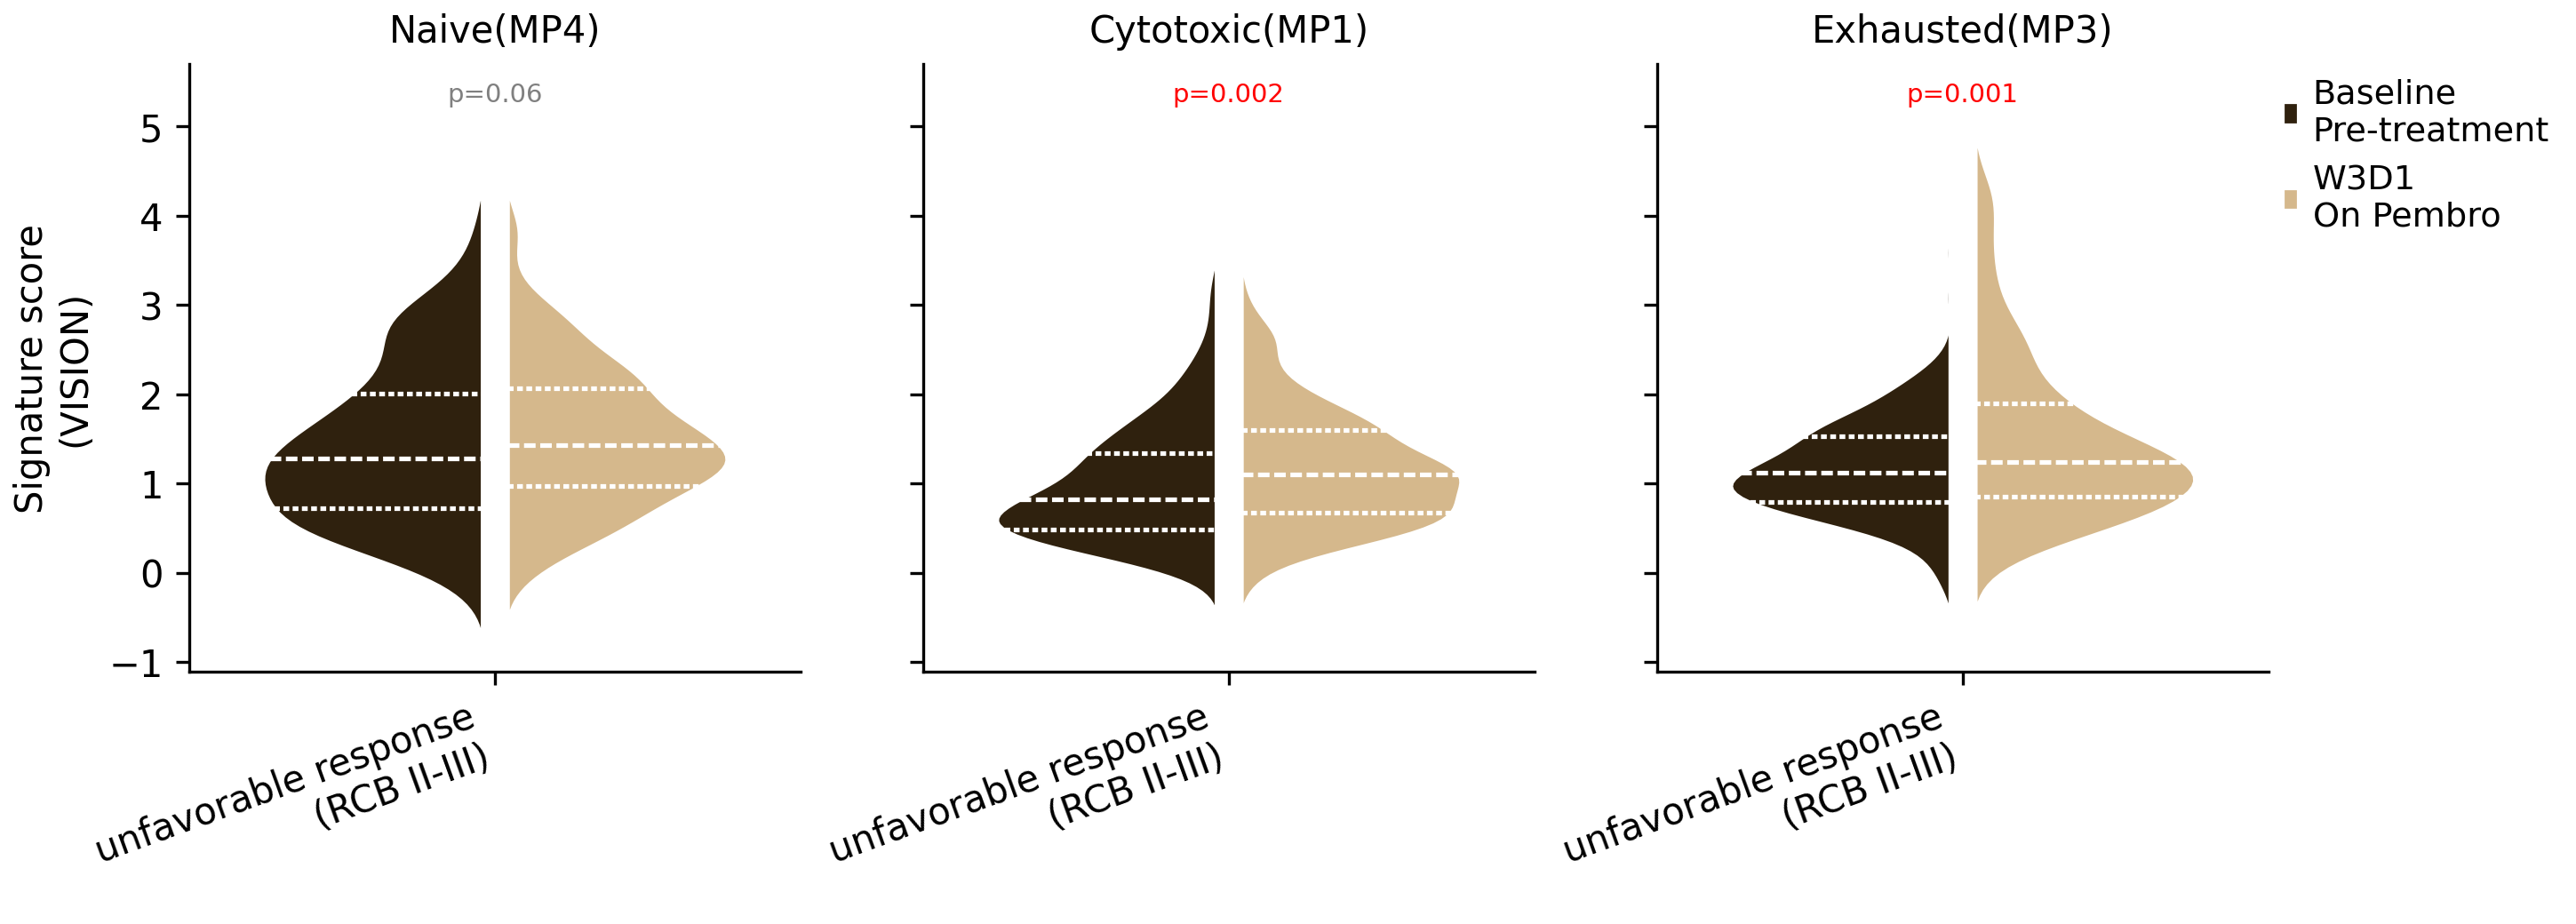

In [38]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,3,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=2:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'Baseline':'Baseline\nPre-treatment',
                        'W3D1':'W3D1\nOn Pembro'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
fig.savefig(f"{FIGURE_FOLDER}/Fig3D_CD8T_MPs_changes_PembroVsBaseline.svg",dpi=200,bbox_inches='tight')

## Combination induced MPs shifts

In [39]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W3D1','W7D1'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['W3D1','W7D1'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         2
unfavorable response\n(RCB II-III)    3
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,W3D1,W7D1,Exhausted(MP3),-0.238419,-0.341626,6.185153103510445e-34,favorable response\n(RCB 0-I)+unfavorable resp...,0.0
0,W3D1,W7D1,Exhausted(MP3),-0.226869,-0.27106,5.485475817692902e-26,favorable response\n(RCB 0-I),0.0
0,W3D1,W7D1,Exhausted(MP3),-0.371991,-0.27106,1.0083776868110116e-08,unfavorable response\n(RCB II-III),0.0
0,W3D1,W7D1,Naive(MP4),0.040218,-0.061276,0.035561284637900835,favorable response\n(RCB 0-I)+unfavorable resp...,0.053342
0,W3D1,W7D1,Cytotoxic(MP1),0.005285,-0.038142,0.7846583456966932,favorable response\n(RCB 0-I)+unfavorable resp...,0.784658
0,W3D1,W7D1,Naive(MP4),0.074595,0.083377,1.0,favorable response\n(RCB 0-I),1.0
0,W3D1,W7D1,Naive(MP4),-0.231581,0.083377,8.741687674630718e-05,unfavorable response\n(RCB II-III),0.000131
0,W3D1,W7D1,Cytotoxic(MP1),0.009158,0.15674,0.6590329092403875,favorable response\n(RCB 0-I),0.988549
0,W3D1,W7D1,Cytotoxic(MP1),-0.026792,0.15674,0.5940393804031696,unfavorable response\n(RCB II-III),0.594039


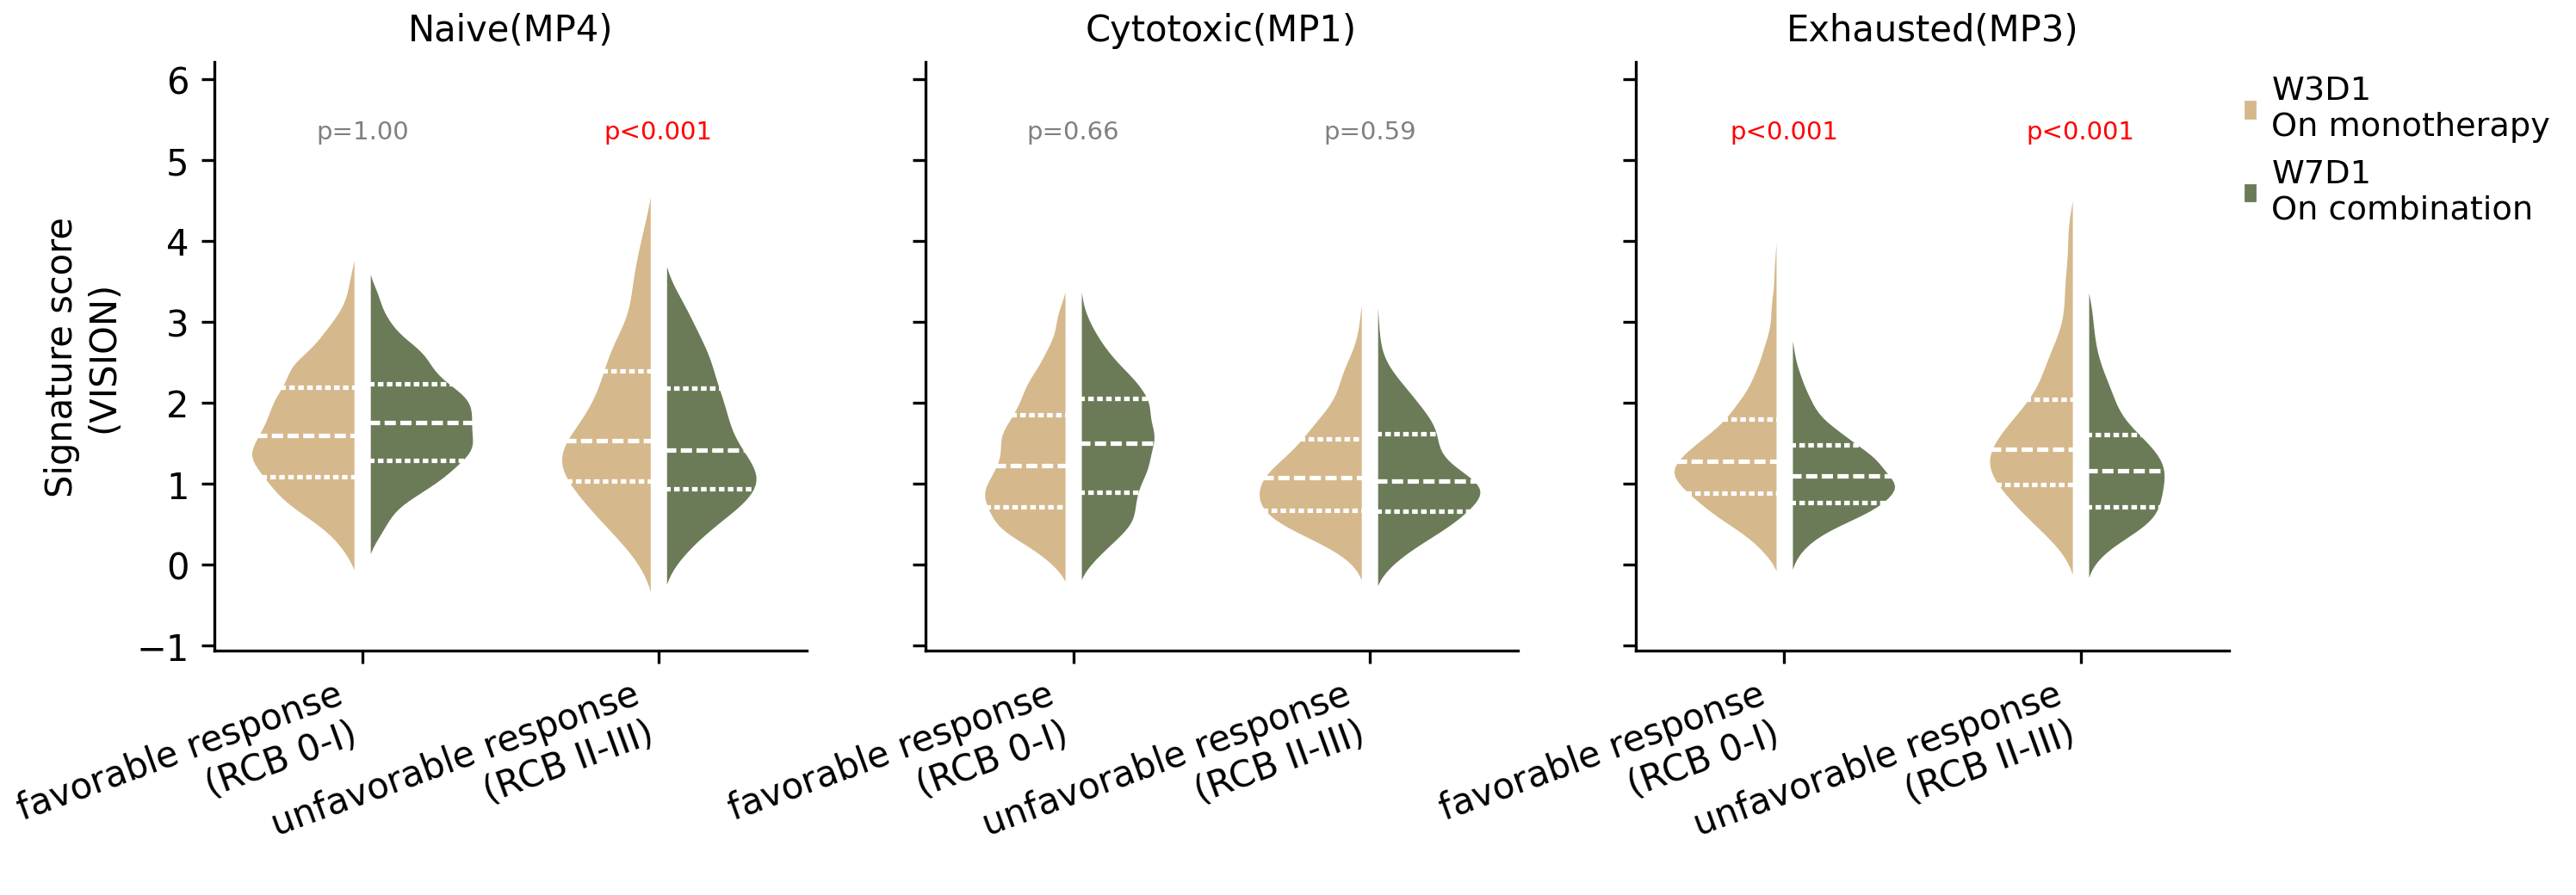

In [41]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,3,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=2:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'W7D1':'W7D1\nOn combination',
                        'W3D1':'W3D1\nOn monotherapy'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
    
fig.savefig(f"{FIGURE_FOLDER}/Fig3E_CD8T_MPs_changes_ComboVsMono.svg",dpi=200,bbox_inches='tight')

## Combination + AC

In [42]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W7D1','Pre-surgery'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['W7D1','Pre-surgery'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         1
unfavorable response\n(RCB II-III)    1
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,W7D1,Pre-surgery,Cytotoxic(MP1),0.210718,-0.038684,0.10244278108829064,favorable response\n(RCB 0-I),0.307328
0,W7D1,Pre-surgery,Cytotoxic(MP1),0.172682,-0.038684,0.0038044487602113056,unfavorable response\n(RCB II-III),0.003804
0,W7D1,Pre-surgery,Exhausted(MP3),-0.127665,0.037521,0.3100602276523196,favorable response\n(RCB 0-I),0.46509
0,W7D1,Pre-surgery,Exhausted(MP3),0.400253,0.037521,1.429204686726373e-07,unfavorable response\n(RCB II-III),0.0
0,W7D1,Pre-surgery,Exhausted(MP3),0.238048,0.11318,0.000352250828968343,unfavorable response\n(RCB II-III)+favorable r...,0.000528
0,W7D1,Pre-surgery,Cytotoxic(MP1),0.184369,0.172634,0.0017825936631638718,unfavorable response\n(RCB II-III)+favorable r...,0.001783
0,W7D1,Pre-surgery,Naive(MP4),0.408128,0.25485,5.968862723317558e-10,unfavorable response\n(RCB II-III)+favorable r...,0.0
0,W7D1,Pre-surgery,Naive(MP4),-0.032245,0.315323,0.803710464663546,favorable response\n(RCB 0-I),0.80371
0,W7D1,Pre-surgery,Naive(MP4),0.603447,0.315323,4.862810546106086e-17,unfavorable response\n(RCB II-III),0.0


In [43]:
dt.groupby([explored_z])['AC_Treatment'].unique()

BestResponse
favorable response\n(RCB 0-I)         [Yes]
unfavorable response\n(RCB II-III)    [Yes]
Name: AC_Treatment, dtype: object

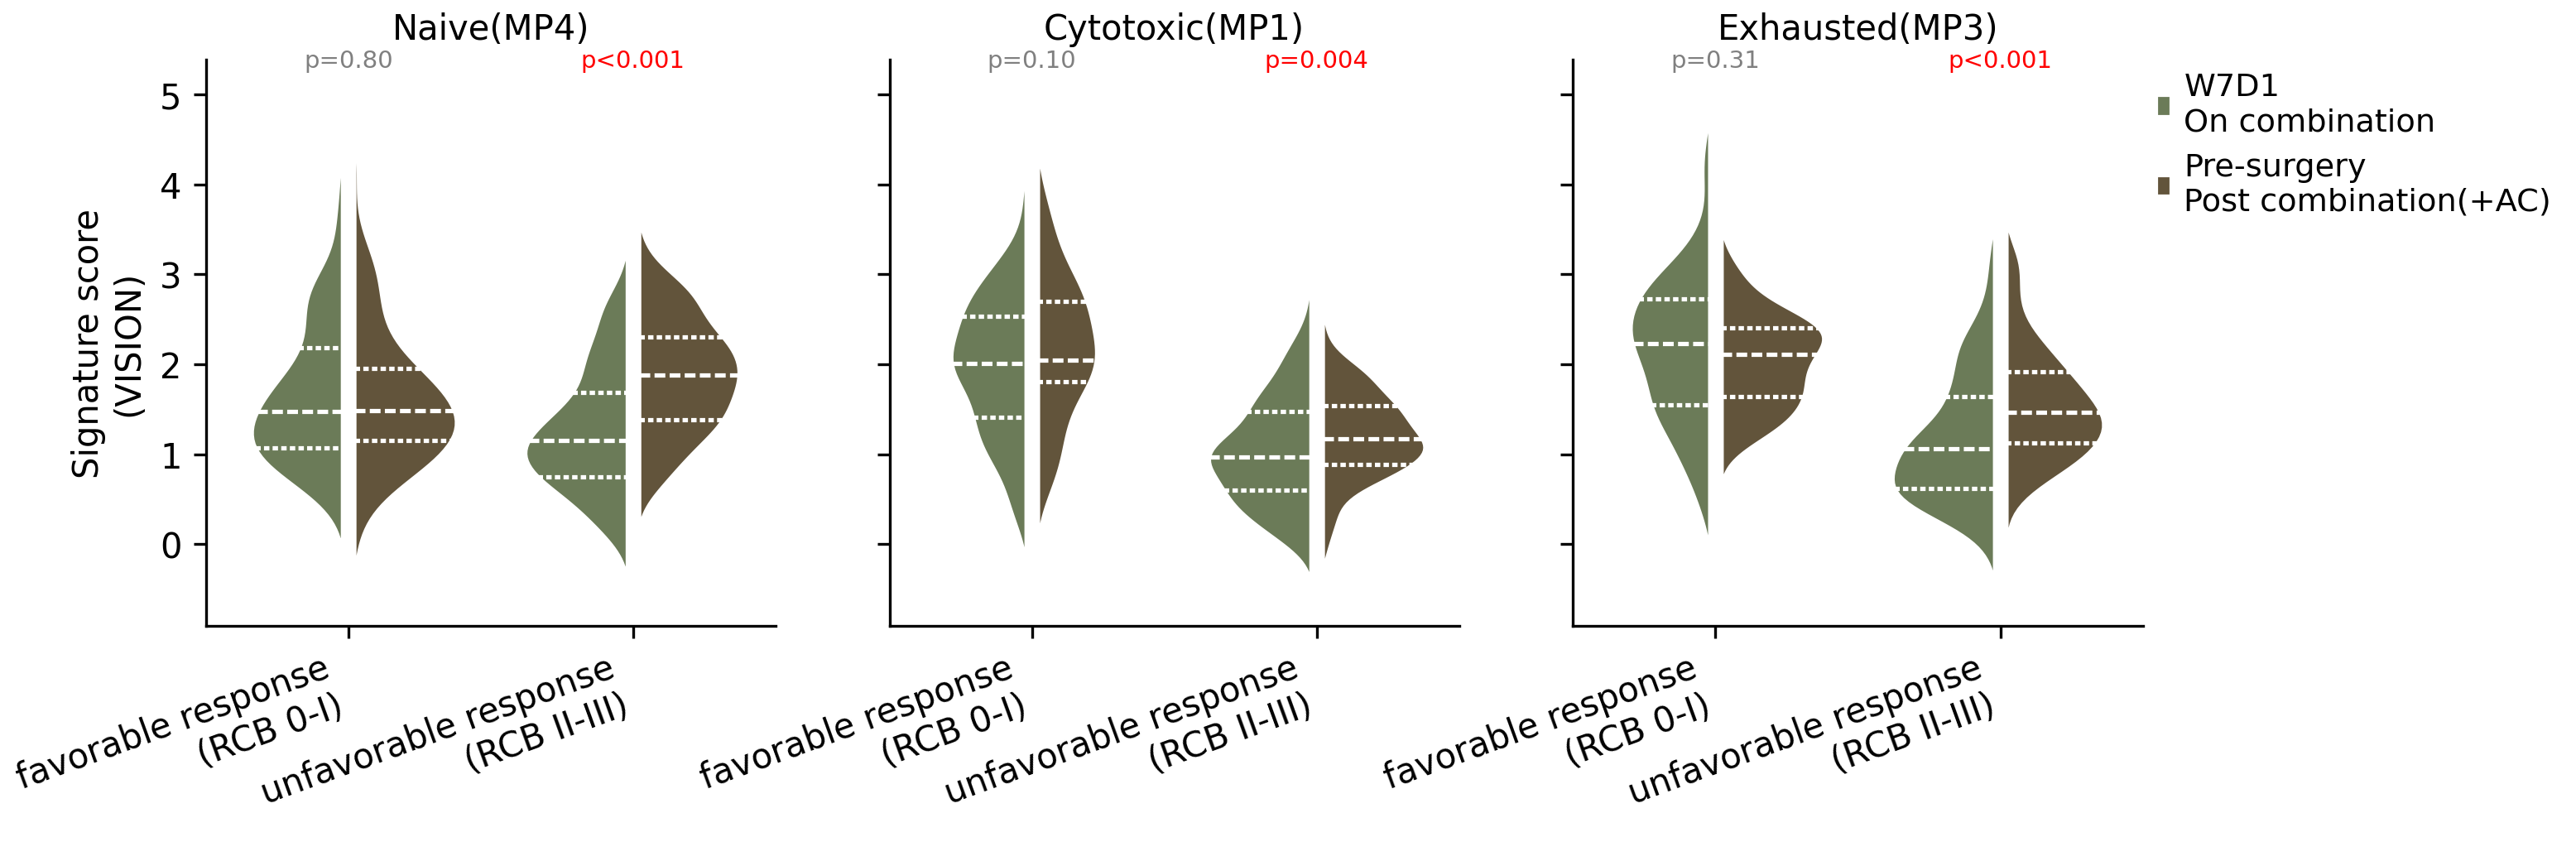

In [45]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,3,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=2:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'W7D1':'W7D1\nOn combination',
                        'Pre-surgery':'Pre-surgery\nPost combination(+AC)'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')

fig.savefig(f"{FIGURE_FOLDER}/Fig3F_CD8T_MPs_changes_postVsCombo.svg",dpi=200,bbox_inches='tight')

## On surgery - post treatment

In [46]:
x='Timepoint'
explored_z='BestResponse'
random_var='Patient'
dt = scores.loc[(scores.Timepoint.isin(['W7D1','Surgery'])),:].copy()
## subsets pts with samples biopsied at both timepoint
paired_pts = dt[['Timepoint',random_var]].drop_duplicates()[random_var].value_counts()
paired_pts = paired_pts[paired_pts>1].index
dt= dt.loc[dt[random_var].isin(paired_pts),:]
## perform linear mixture model test
dt[x] = pd.Categorical(dt[x],['W7D1','Surgery'],ordered=True)
print(dt.groupby(explored_z)[random_var].nunique())
dt[explored_z] = dt[explored_z].astype(str)
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var).drop_duplicates(['Y','BestResponse'])
result.Y =  result.Y.map(MP_anno_map)
result

BestResponse
favorable response\n(RCB 0-I)         1
unfavorable response\n(RCB II-III)    0
Name: Patient, dtype: int64


,Ctrl,Experiment,Y,Coef,log2FC,Pvalue,BestResponse,FDR
0,W7D1,Surgery,Exhausted(MP3),-0.090399,-0.09945,0.1957855640892844,favorable response\n(RCB 0-I),0.293678
0,W7D1,Surgery,Naive(MP4),0.039314,0.025144,0.7526754296582303,favorable response\n(RCB 0-I),0.752675
0,W7D1,Surgery,Cytotoxic(MP1),0.408034,0.432831,5.996741659591649e-05,favorable response\n(RCB 0-I),0.00018


In [47]:
dt.groupby([explored_z])['AC_Treatment'].unique()

BestResponse
favorable response\n(RCB 0-I)    [No]
Name: AC_Treatment, dtype: object

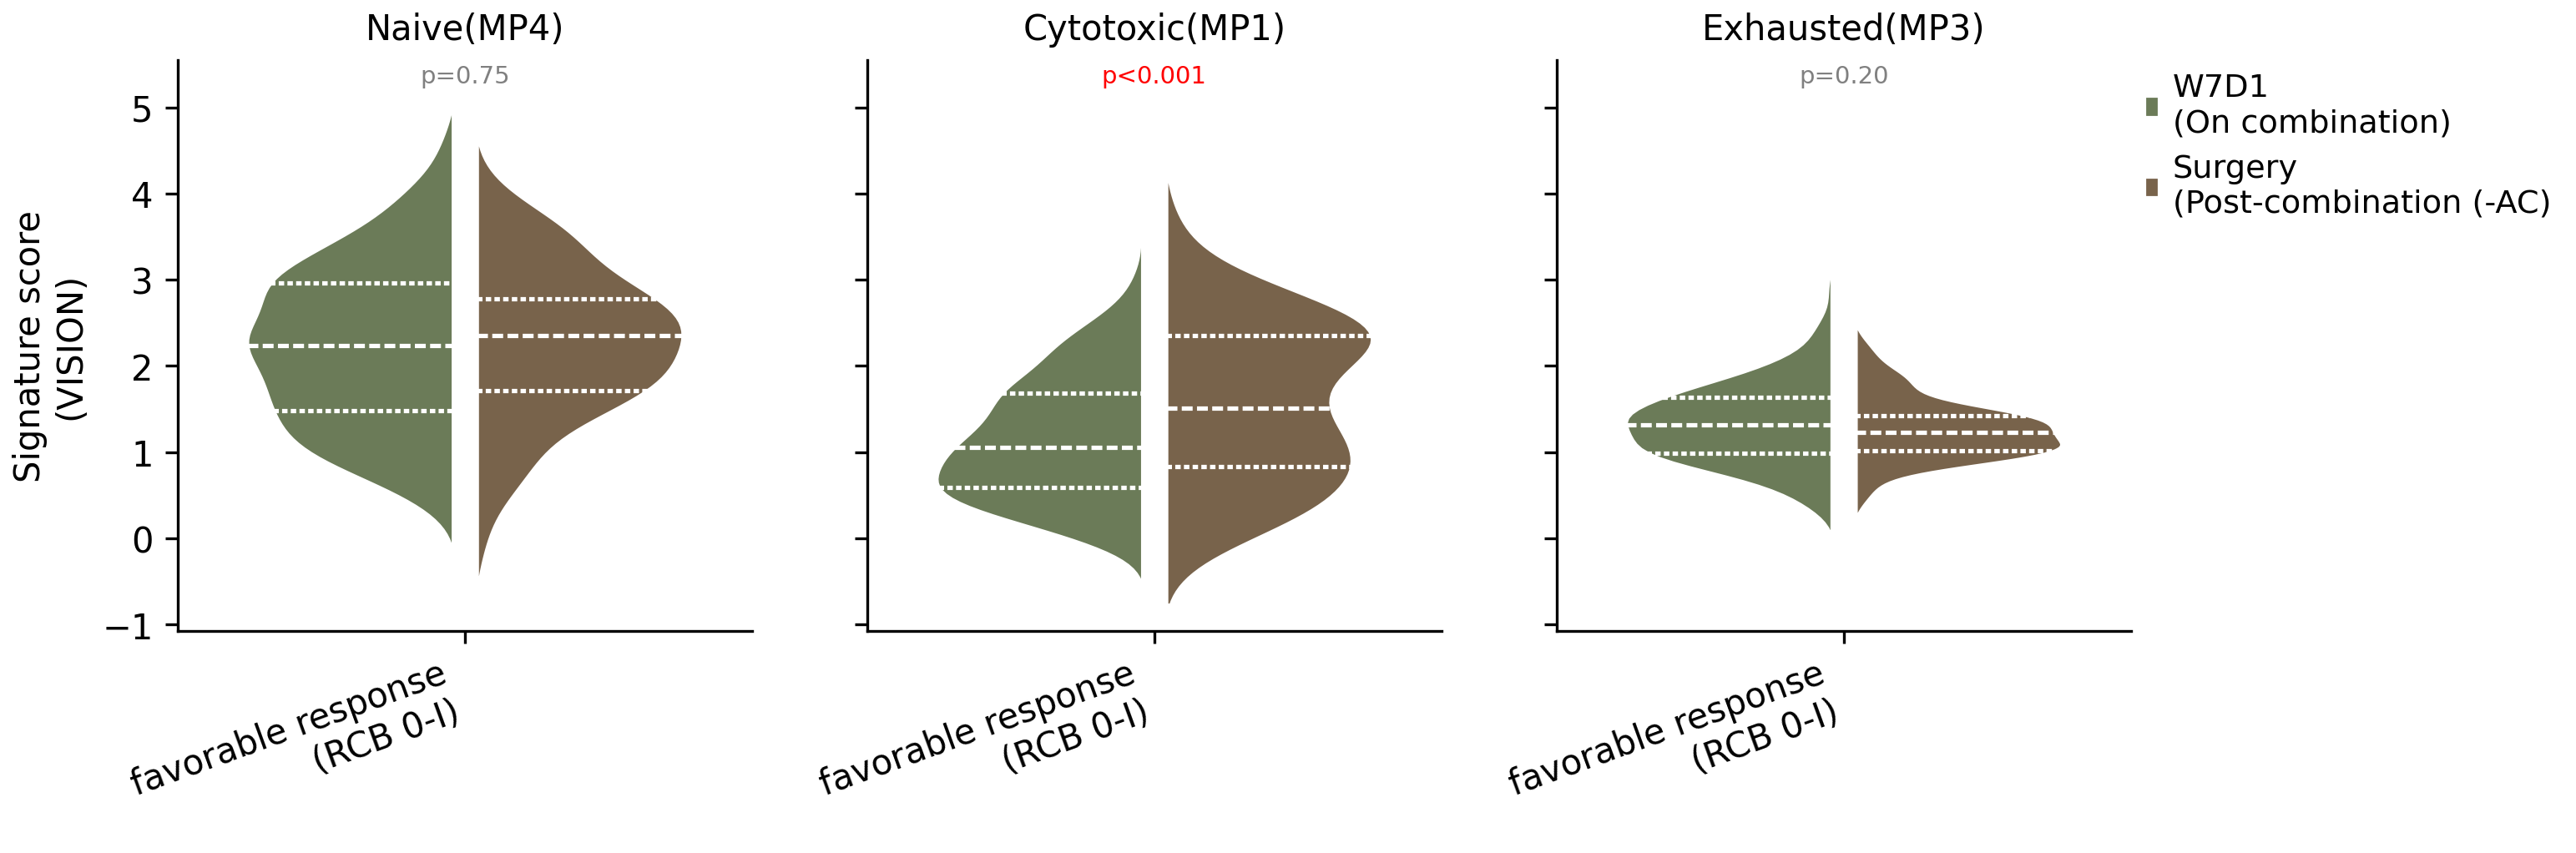

In [49]:
pvalues = result.set_index(['Y',explored_z])['Pvalue']
plt_dt = dt.rename(columns=MP_anno_map)
fig,axs=plt.subplots(1,3,dpi=150,sharey=True,figsize=(10,3))
for i,subtype in enumerate(show_mps):
    ax=axs[i]
    sns.violinplot(data=plt_dt,
                  x='BestResponse',y=subtype,hue='Timepoint',
                  ax=ax,
                  split=True, gap=.1, inner="quart",linecolor='white',
                  palette=COLOR_PAlETTE['Timepoint'])

    ## Add pvalue
    y_loc =5.5
    for xtick in ax.get_xticklabels():
        x_loc,_ = xtick.get_position()
        text = xtick.get_text()
        if pvalues[subtype,text] >= 0.05:
            c='gray'
            label = f"p={pvalues[subtype,text]:.2f}"
        elif pvalues[subtype,text] >= 0.01:
            label = f"p={pvalues[subtype,text]:.2f}"
            c = 'red'
        elif pvalues[subtype,text] >= 0.001:
            label = f"p={pvalues[subtype,text]:.3f}"
            c = 'red'
        else:
            label = "p<0.001"
            c = 'red'
        ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c,fontsize=7)
    ### rename legend label
    if i !=2:
        ax.legend_.remove()
    else:
        handles, previous_labels = ax.get_legend_handles_labels()
        new_labels = [ {'W7D1':'W7D1\n(On combination)',
                        'Surgery':'Surgery\n(Post-combination (-AC)'}[text]for text in previous_labels]
        ax.legend(loc=(1,.7),handles=handles, labels=new_labels)
    ax.set(xlabel='',title=subtype,ylabel='Signature score\n(VISION)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')

fig.savefig(f"{FIGURE_FOLDER}/Suppl_3G_CD8T_MPs_changes_surgeryVsCombo.svg",dpi=200,bbox_inches='tight')

# Cytokine

In [50]:
cytosig = pd.read_csv(f'{RESULT_TABLE}/cytoSig_zscore.csv',index_col=0)
cytosig.columns = cytosig.columns.map(lambda x:x.split('.')[1]) # remove the cell type prefix
cytosig = cytosig[obs.index.intersection(cytosig.columns)].T

## Exhausted vs Cytotoxic

In [51]:
dt = obs.merge(cytosig,left_index=True,right_index=True,how='right')
sp_cytokine = dt.groupby(['Cellstate','CCG_ID']).mean().dropna(how='all',axis=0).reset_index()
sp_cytokine = sp_cytokine.loc[sp_cytokine.Cellstate!='CD8T.Naive',:]

In [52]:
from statsmodels.stats.multitest import multipletests

stats_res = []
for cellstate,expr in sp_cytokine.groupby('Cellstate'):
    expr = expr.set_index('CCG_ID').drop(['Cellstate'],axis=1)
    ctrl = sp_cytokine.loc[sp_cytokine.Cellstate!=cellstate,:].set_index('CCG_ID').drop(['Cellstate'],axis=1)
    stats_res.append(
        expr.apply(lambda c: pd.Series(list(scipy.stats.ranksums(c.values,ctrl[c.name].values))+[cellstate],
                                       index=['Zscore','Pvalue','Cellstate']
                                      ),axis=0
                  ).T.reset_index()
    )
    
stats_res = pd.concat(stats_res)

In [53]:
(stats_res.loc[stats_res.Pvalue<0.05,:].
 pivot(index='index',columns='Cellstate',values='Zscore').
 sort_values('CD8T.Exhausted',ascending=False)
)

Cellstate,CD8T.Cytotoxic,CD8T.Exhausted
index,,
IL15,-3.036558,3.036558
CD40L,-2.208406,2.208406
GMCSF,-2.109028,2.109028
TRAIL,-2.00965,2.00965
IL22,2.131112,-2.131112
IL10,2.351952,-2.351952
BMP4,2.429247,-2.429247


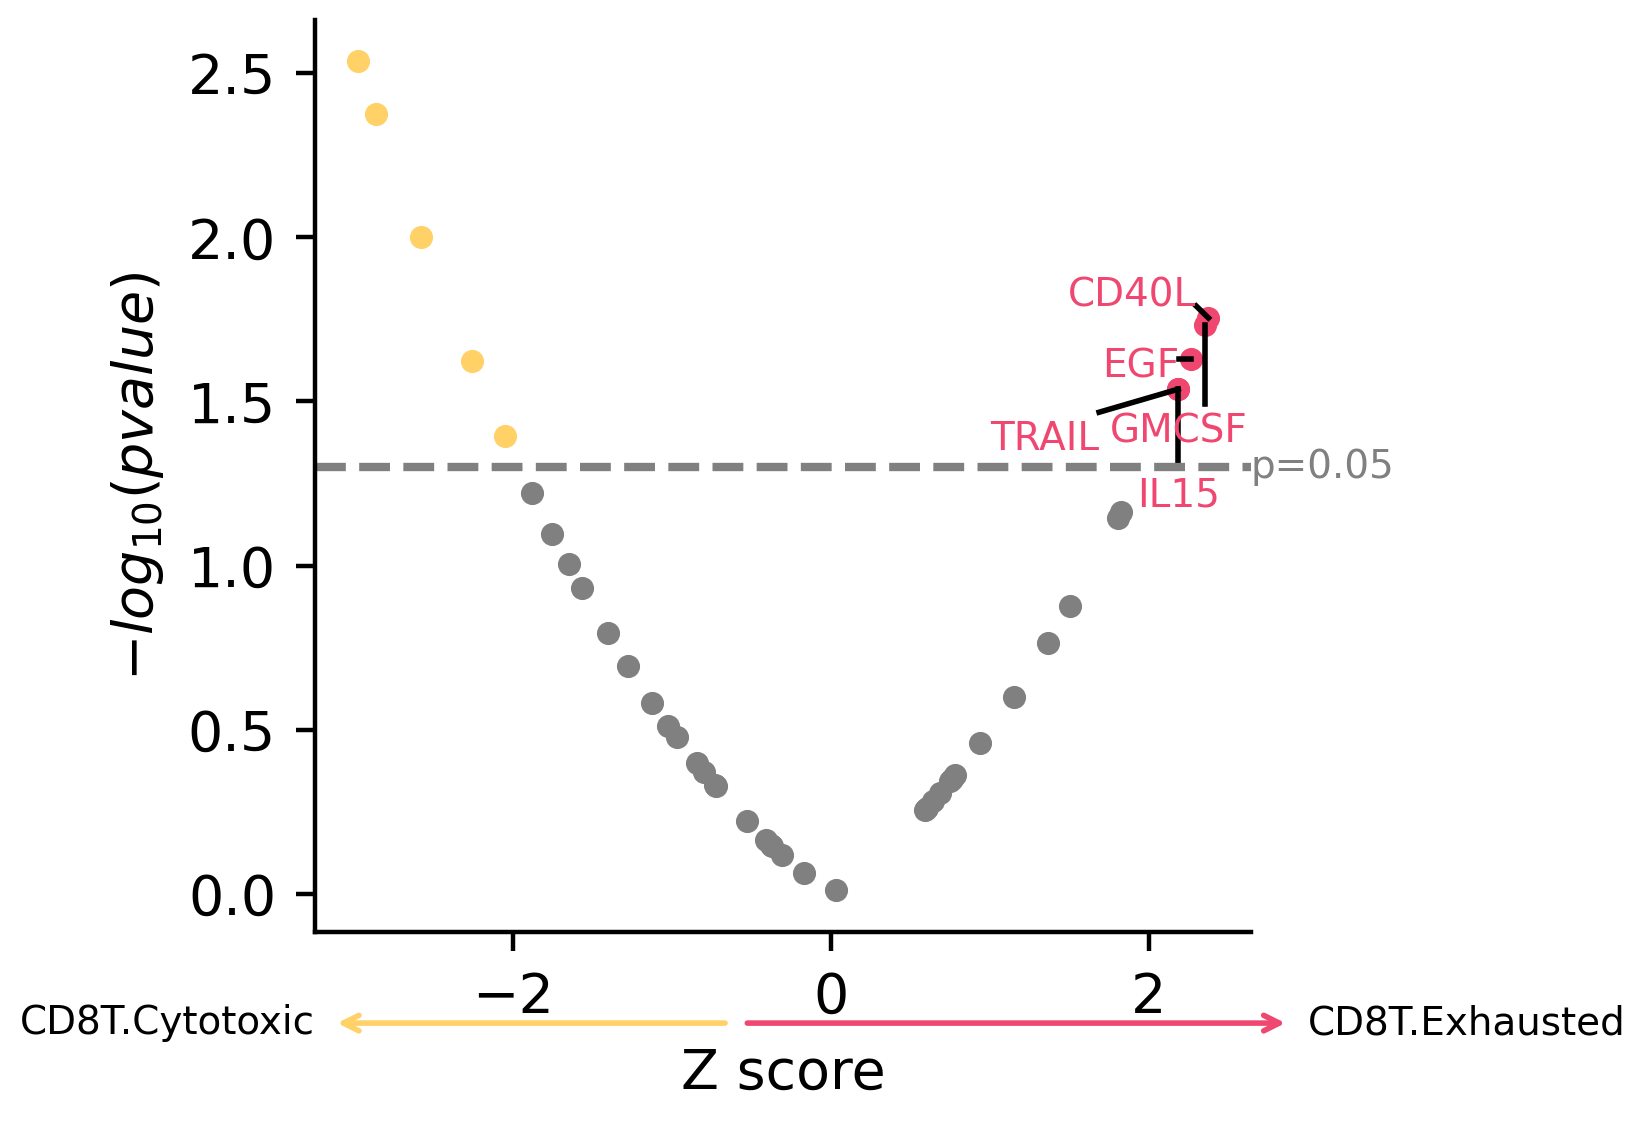

In [58]:
import textalloc as ta
plt_dt = stats_res.loc[stats_res.Cellstate=='CD8T.Exhausted',:]
fig,ax=plt.subplots(1,1,figsize=(3,3),dpi=200)
ns = plt_dt.index[plt_dt.Pvalue>=0.05]
signif_pos = plt_dt.index[(plt_dt.Pvalue<0.05)&(plt_dt.Zscore>0)]
signif_neg = plt_dt.index[(plt_dt.Pvalue<0.05)&(plt_dt.Zscore<0)]
ax.scatter(plt_dt.loc[ns,'Zscore'],-np.log10(plt_dt.loc[ns,'Pvalue'].astype(float)),s=10,c='gray')
ax.scatter(plt_dt.loc[signif_pos,'Zscore'],-np.log10(plt_dt.loc[signif_pos,'Pvalue'].astype(float)),s=10,c=COLOR_PAlETTE['Cellstate']['CD8T.Exhausted'])
ax.scatter(plt_dt.loc[signif_neg,'Zscore'],-np.log10(plt_dt.loc[signif_neg,'Pvalue'].astype(float)),s=10,c=COLOR_PAlETTE['Cellstate']['CD8T.Cytotoxic'])
## Text annotation
t_x = plt_dt.loc[signif_pos,'Zscore'].values
t_y = -np.log10(plt_dt.loc[signif_pos,'Pvalue'].astype(float)).values
t_s = plt_dt.loc[signif_pos,'index'].values
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['Cellstate']['CD8T.Exhausted'],
            textsize=7,
            linecolor='k')

# t_x = plt_dt.loc[signif_neg,'Zscore'].values
# t_y = -np.log10(plt_dt.loc[signif_neg,'Pvalue'].astype(float)).values
# t_s = plt_dt.loc[signif_neg,'index'].values
# ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
#             textcolor=COLOR_PAlETTE['Cellstate']['CD8T.Cytotoxic'],
#             textsize=7,
#             linecolor='k')

## p-value indication
ax.axhline(y=-np.log10(0.05),c='gray',ls='--')
ax.text(ax.get_xlim()[1],-np.log10(0.05),'p=0.05',ha='left',va='center',size=7,color='gray')


## axis title
ax.set(ylabel=r'$-log_{10}(p value)$',xlabel='Z score')

## arrow indication
center =.45
down_zero = -0.1
name ='CD8T.Exhausted'
ax.annotate(name, xy=(center, down_zero), xycoords='axes fraction', xytext=(1.4, down_zero), 
            arrowprops=dict(arrowstyle="<-", color=COLOR_PAlETTE['Cellstate']['CD8T.Exhausted']),ha='right',va='center')
name ='CD8T.Cytotoxic'
ax.annotate(name, xy=(center, down_zero), xycoords='axes fraction', xytext=(0, down_zero), 
            arrowprops=dict(arrowstyle="<-",  color=COLOR_PAlETTE['Cellstate']['CD8T.Cytotoxic']),ha='right',va='center')
fig.savefig(f"{FIGURE_FOLDER}/Fig3B_CD8T_cytokine_two_state_volcano.svg",dpi=200,bbox_inches='tight')

## Exhausted vs rest

In [56]:
from statsmodels.stats.multitest import multipletests
sp_cytokine = dt.groupby(['Cellstate','CCG_ID']).mean().dropna(how='all',axis=0).reset_index()
stats_res = []
for cellstate,expr in sp_cytokine.groupby('Cellstate'):
    expr = expr.set_index('CCG_ID').drop(['Cellstate'],axis=1)
    ctrl = sp_cytokine.loc[sp_cytokine.Cellstate!=cellstate,:].set_index('CCG_ID').drop(['Cellstate'],axis=1)
    stats_res.append(
        expr.apply(lambda c: pd.Series(list(scipy.stats.ranksums(c.values,ctrl[c.name].values))+[cellstate],
                                       index=['Zscore','Pvalue','Cellstate']
                                      ),axis=0
                  ).T.reset_index()
    )
    
stats_res = pd.concat(stats_res)

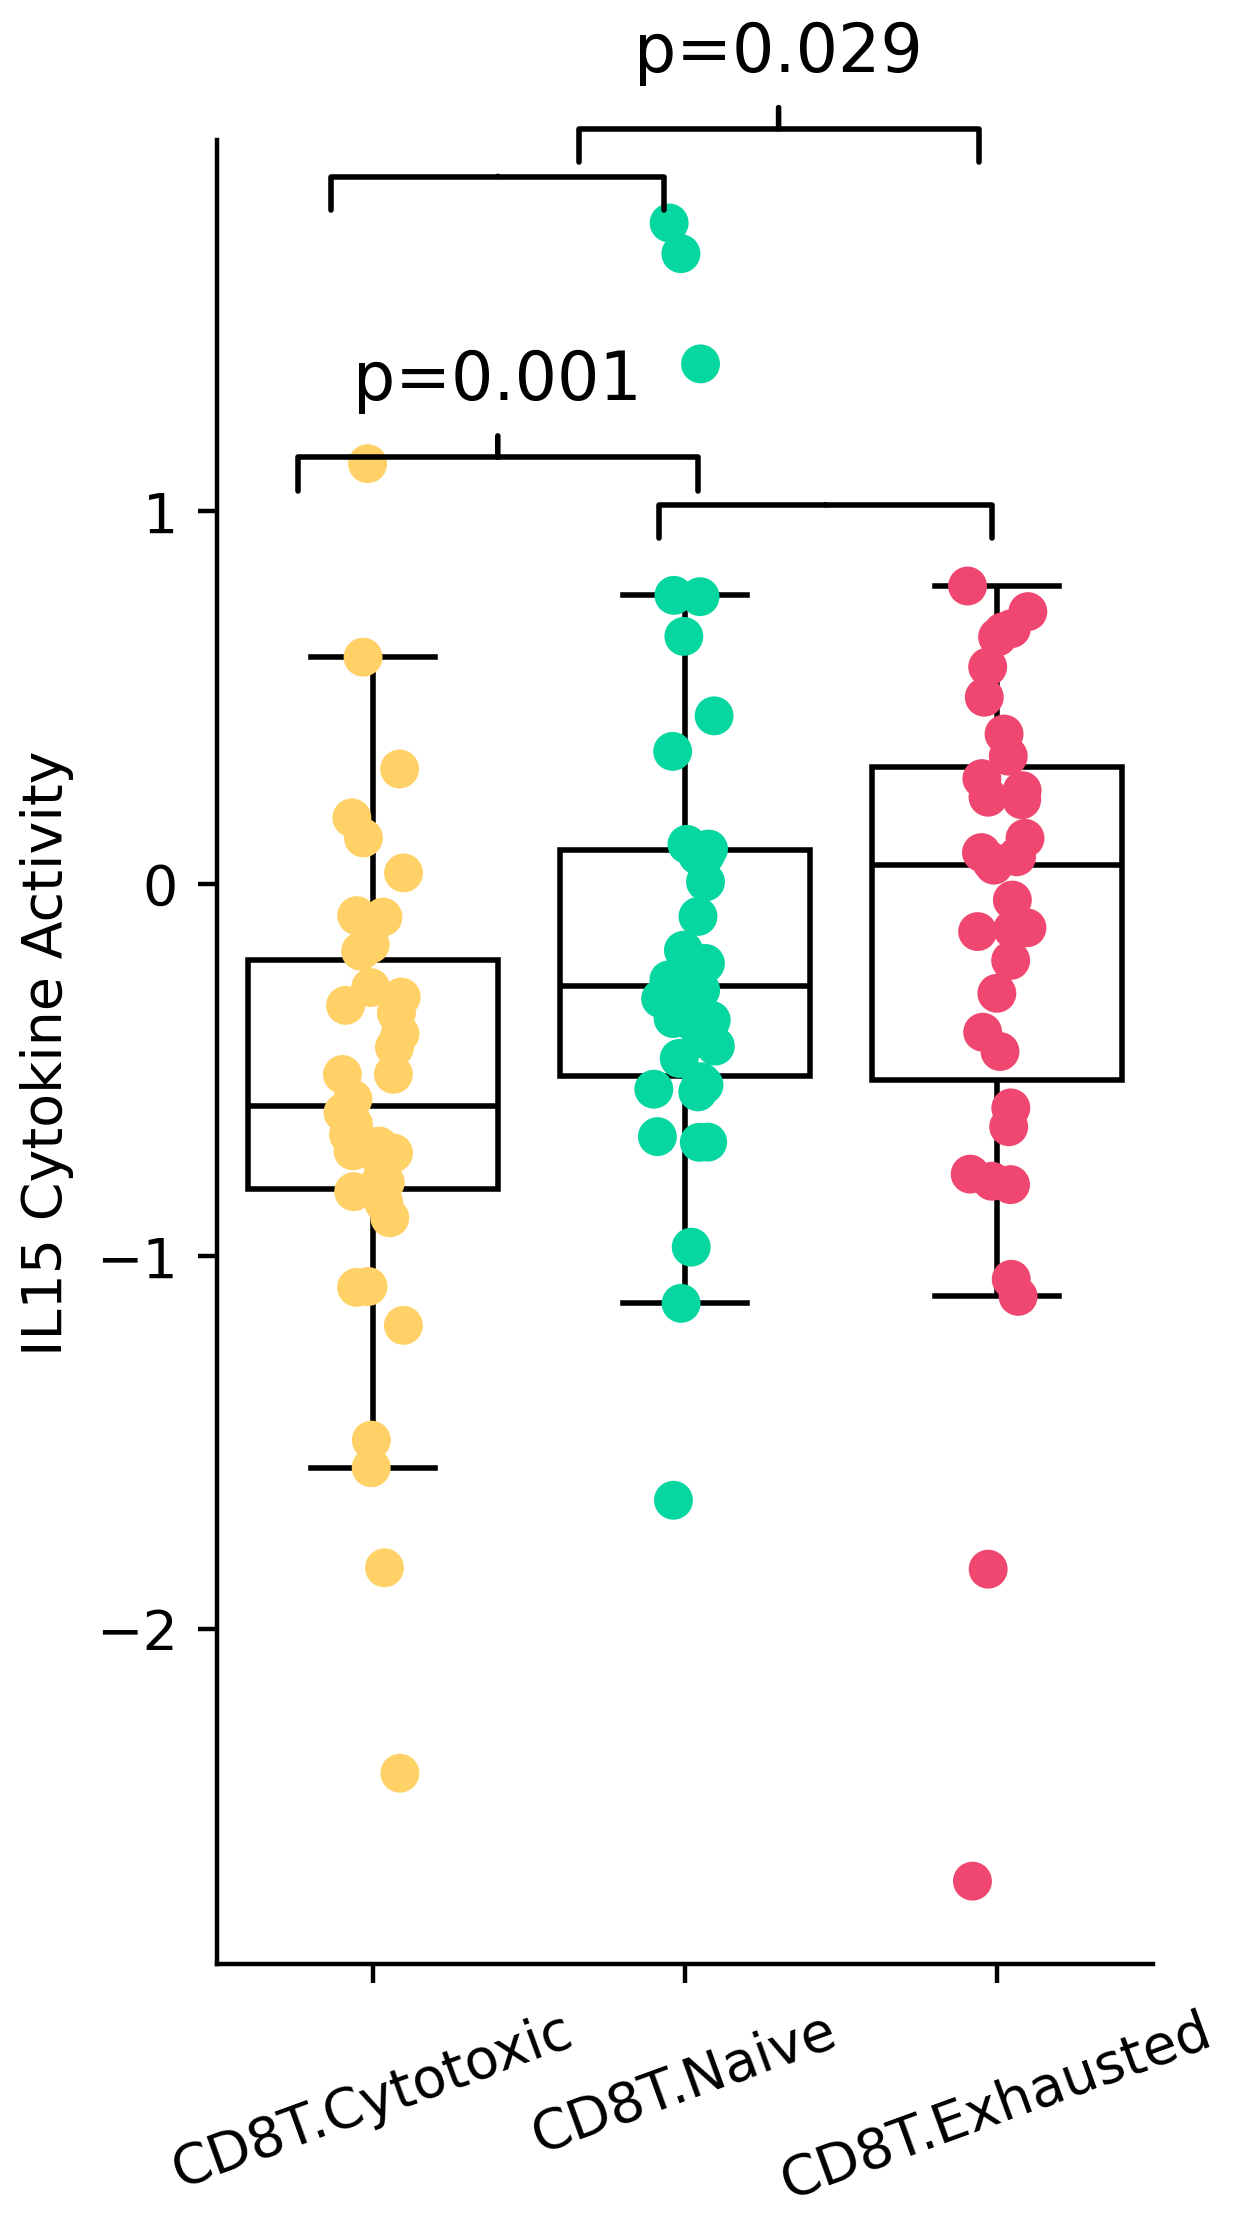

In [57]:
fig,ax=plt.subplots(1,1,figsize=(3,6),dpi=200)

cytokine_name = 'IL15'
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
sns.stripplot(data=sp_cytokine,x='Cellstate',y=cytokine_name,
              order=['CD8T.Cytotoxic','CD8T.Naive','CD8T.Exhausted'],
              ax=ax,palette=COLOR_PAlETTE['Cellstate'],size=7)
sns.boxplot(data=sp_cytokine,x='Cellstate',y=cytokine_name,
            order=['CD8T.Cytotoxic','CD8T.Naive','CD8T.Exhausted'],
            ax=ax,showfliers=False,linewidth=1,**PROPS)
ax.tick_params(axis='x',rotation=20)
pvalue = stats_res.loc[(stats_res['index']==cytokine_name)&
              (stats_res.Cellstate=='CD8T.Exhausted'),'Pvalue'].values[0]
ax.annotate(f"p={pvalue:.3f}", xy=(0.6, 1), xytext=(0.6, 1.03), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=3, lengthB=.5', lw=1, color='k'))
ax.annotate('', xy=(0.3, .98), xytext=(0.3, .9801), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'));


pvalue = stats_res.loc[(stats_res['index']==cytokine_name)&
              (stats_res.Cellstate=='CD8T.Cytotoxic'),'Pvalue'].values[0]
ax.annotate(f"p={pvalue:.3f}", xy=(0.3, .82), xytext=(0.3, .85), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=3, lengthB=.5', lw=1, color='k'))
ax.annotate('', xy=(0.65, .8), xytext=(0.65, .8001), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'));

ax.set(xlabel='',ylabel=f'{cytokine_name} Cytokine Activity')
fig.savefig(f"{FIGURE_FOLDER}/Fig3C_CD8T_cytokine_three_state_boxplot.svg",dpi=200,bbox_inches='tight')